Groundwater | Case Study

# Topic 4 : From Concept to Code: Implementing the Limmat Valley Model

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

In [1]:
# Import libraries
# Import libraries
import sys
import os
import time
import pandas as pd
import geopandas as gpd
import pickle
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union, linemerge
from shapely.affinity import rotate, translate, scale
from scipy.interpolate import griddata
import rasterio
from rasterio.warp import reproject, Resampling, transform_bounds
from rasterstats import zonal_stats


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import flopy
import flopy.plot as fpl
from flopy.discretization import StructuredGrid
from flopy.utils import Raster, GridIntersect

# Add the support repo to the path
sys.path.append('../SUPPORT_REPO/src')
sys.path.append('../SUPPORT_REPO/src/scripts/scripts_exercises')

# Import local modules
from data_utils import (
    download_named_file, 
    get_default_data_folder, 
    fast_resample_dem_to_modelgrid
)
from print_images import display_image
from progress_tracking import (
    create_model_implementation_progress_tracker, 
    create_nested_step_completion_marker, 
)
from grid_utils import build_grid_gdf_and_ibound
from river_utils import compute_medial_centerlines

Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Documents/GitHub/applied_groundwater_modelling (marker: config.py)
Loaded configuration from 'config.py'


In the previous steps, we defined our modeling objectives and developed a perceptual model of the Limmat Valley aquifer. We gathered data on the aquifer's geometry, its boundaries, and the key hydrological processes like recharge and river interaction.

Now, we will translate this perceptual understanding into a numerical groundwater model using **MODFLOW 2005** and the Python package **FloPy**. This means we describe the aquifer with numbers and grids, so a computer can simulate water movement. This process involves several key steps:

1.  **Discretization:** Defining the model grid (layers, rows, columns) that will represent our aquifer in space.
2.  **Parameterization:** Assigning hydraulic properties (like conductivity and storage) to the grid cells.
3.  **Boundary Conditions:** Implementing the physical boundaries of our system, such as rivers, recharge, and wells.
4.  **Solving:** Choosing a numerical solver and running the simulation.
5.  **Post-processing:** Visualizing and analyzing the initial results.

You can use the checklist below to keep track of your progress:

In [2]:
create_model_implementation_progress_tracker()

📂 Loaded saved progress for Model Implementation


Checkbox(value=False, description='Step 1: Workspace Setup', indent=False, layout=Layout(margin='8px 0px', wid…

Checkbox(value=False, description='Step 2.1: Discretization - Grid Creation', indent=False, layout=Layout(marg…

Checkbox(value=False, description='Step 2.2: Discretization - Model Top (DEM Resampling)', indent=False, layou…

Checkbox(value=False, description='Step 2.3: Discretization - Aquifer Thickness & Bottom', indent=False, layou…

Checkbox(value=False, description='Step 2.4: Discretization - Writing DIS Package', indent=False, layout=Layou…

Checkbox(value=False, description='Step 3: Paramterization - Layer-Property Flow (LPF) Package', indent=False,…

Checkbox(value=False, description='Step 4.1: Boundary & Initial Conditions - Active Cells, Basic (BAS) Package…

Checkbox(value=False, description='Step 4.2: Boundary & Initial Conditions - Lateral Outflow (CHD Package)', i…

Checkbox(value=False, description='Step 4.3: Boundary & Initial Conditions - Areal Recharge (RECH Package)', i…

Checkbox(value=False, description='Step 4.4: Boundary & Initial Conditions - Pumping and Lateral Inflow (WEL P…

Checkbox(value=False, description='Step 4.5: Boundary & Initial Conditions - River Package (RIV) & Stage Check…

Checkbox(value=False, description='Step 5: Solver & Output Control', indent=False, layout=Layout(margin='8px 0…

Checkbox(value=False, description='Step 6: Running the simulation', indent=False, layout=Layout(margin='8px 0p…

Checkbox(value=False, description='Step 7: Post Processing & Visualization', indent=False, layout=Layout(margi…

## 1 Workspace Setup
Let's begin by setting up our model workspace. This involves creating a flopy workspace that we will fill with the model grid, boundary conditions, and other necessary components as we progress through the case study.

In [3]:
# Define the name of our model and the workspace where files will be stored.
# We'll create a directory in your default data folder for this course to keep 
# things organized. 
model_name = 'limmat_valley_model'
workspace = os.path.join(get_default_data_folder(), model_name)

# Create the workspace directory if it doesn't exist
os.makedirs(workspace, exist_ok=True)

# Define the path to the MODFLOW executable
# We assume it's in a standard location accessible from the system's PATH.
executable = 'mf2005' 

# Create the MODFLOW model object
# The model object is the main object in FloPy that represents the MODFLOW model.
# It manages all the information about the model, including the grid, boundary 
# conditions, and other settings.
# We'll fill it with the necessary components as we go along.
mf = flopy.modflow.Modflow(
    modelname=model_name, 
    model_ws=workspace, 
    exe_name=executable
)

In [4]:
create_nested_step_completion_marker(1)

Checkbox(value=False, description='✅ Yes, I have completed Step 1: Workspace Setup', indent=False, layout=Layo…

Output()

## 2 Discretization (DIS) Package
The DIS package defines the geometry and time discretization of a MODFLOW model. It tells MODFLOW how the model domain is divided into layers, rows, and columns, and how time is represented in stress periods.

Key inputs are:  
- Spatial discretization:  
    - nlay, nrow, ncol – number of layers, rows, and columns.  
    - delr, delc – cell sizes in the row and column directions.  
    - top – array of top elevations of the model domain.  
    - botm – arrays of bottom elevations for each layer.  
- Temporal discretization:  
    - nper – number of stress periods.  
    - perlen – length of each stress period.  
    - nstp – number of time steps per stress period.  
    - tsmult – time step multiplier (controls time-step progression).  
    - steady – flag indicating whether a period is steady-state or transient.  

The DIS package is the foundation of the model: all other packages (boundary conditions, hydraulic properties, solute transport) build on the grid and time discretization it defines.

### 2.1 Model Grid

The first step is to define the spatial domain of our model. Based on our perceptual model, we will create a single-layer model. A single-layer model is a 2D model. This 2D model can still represent thickness and vertical flows. For this reason, people sometimes call it quasi-3D or 2.5D. 

We choose a grid size of 50 meters by 50 meters to start with. This means that each grid cell will represent a 50m x 50m area in the real world. This is a compromise between detail and computational efficiency. It will not allow us to capture small-scale features, but it will provide a good overview of the aquifer's behavior. We can refine the grid later in the modelling process if needed and we can assess the impact of the model resolution on the results in the sensitivity analysis.

We start with an initial grid and then rotate it to align with the flow direction. This will help us reduce the number of model cells and speed up the model run time.

#### 2.1.1 Data processing: Build the model grid
This cell creates a simple, uniform structured grid aligned to the case-study boundary. It reads the boundary polygon, derives grid dimensions from a chosen cell size, and instantiates a FloPy `StructuredGrid` with a defined origin and an initial rotation (set to 0° here for a clean baseline). Use this as a starting point before refining rotation or replacing the dummy elevations.  

- Inputs: `boundary_path` (GeoPackage/GeoJSON), `cell_size` (m)
- Steps: (1) load boundary, (2) compute grid extent and `nrow`/`ncol`, (3) build uniform `delr`/`delc` and the grid,
- Outputs: `modelgrid` (FloPy `StructuredGrid`) with origin, CRS, and rotation set,

Note: Rotation is initially 0° to verify alignment. After inspection, update the angle (or use the rotation-iteration helper) and recompute the grid artifacts so downstream visualization, MODFLOW setup, and exports use the chosen rotation.

In [5]:
# Goal: Compute a structured grid aligned to the model boundary. 
# Inputs: 
# - Path to the model boundary polygon `boundary_path` (string)
# - Desired cell size `cell_size` (float)
# Steps:
# 1. Get the model boundary polygon
# 2. Compute the grid dimensions based on the boundary and cell size
# 3. Create the structured grid
# Outputs: 
# - Structured grid object `modelgrid` (FloPy StructuredGrid)

# --- 0. Inputs --- 
# Path to the model boundary polygon
boundary_path = download_named_file(
    name='model_boundary',
    data_type='gis'
)

# Desired cell size
cell_size = 50  # meters

# --- 1. Get the model boundary polygon --- 
gdf = gpd.read_file(boundary_path)

# --- 2. Compute the grid dimensions based on the boundary and cell size ---
# Get the bounding box of the geometry in your GeoPackage
# Assuming you want to use the total bounds of all geometries in the GeoPackage
xmin, ymin, xmax, ymax = gdf.total_bounds

# Rotation of the grid to minimize the number of cells. The grid is rotated 
# around the lower left corner (xll, yll).
rotation = 0  # degrees, let's first see how it looks without rotation.

# Calculate number of rows and columns
ncol = int(np.ceil((xmax - xmin) / cell_size))
nrow = int(np.ceil((ymax - ymin) / cell_size))

# Define delr and delc (cell widths along rows and columns)
# Delr and delc are the widths of the grid cells in the x and y directions, respectively.
# Here, we assume a uniform grid, so we can use the same cell size for all cells.
# If you have varying cell sizes, you would need to define them accordingly.
# For a non-uniform grid, you would typically provide arrays of varying sizes.
# Here, we use np.full to create arrays filled with the cell_size value.
# For a regular grid, these will be arrays of the cell_size
delr = np.full(ncol, cell_size)
delc = np.full(nrow, cell_size)

# Define the origin of the grid (lower-left corner)
# FloPy by default assumes the origin (xll, yll) is the lower-left corner
xll = xmin
yll = ymin

# We define the number of layers in the model.
nlay = 1

# We use dummy data for the top and the bottom elevation for now. We'll replace 
# these with actual data later.
top = np.ones((nrow, ncol)) * 100 # Dummy top elevation
botm = np.ones((nlay, nrow, ncol)) * 50 # Dummy bottom elevation

# Create the structured grid object
# The StructuredGrid object is used to define the grid structure in FloPy.
# Check out the documentation for more details: 
# https://flopy.readthedocs.io/en/stable/source/flopy.discretization.structuredgrid.html
modelgrid = StructuredGrid(
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=xll,
    yoff=yll,
    angrot=rotation,
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)
print("Model grid created with the following parameters:")
print(modelgrid)

limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Model grid created with the following parameters:
xll:2676732.1290222453; yll:1246750.8207069656; rotation:0; crs:EPSG:2056; units:meters; lenuni:2


#### 2.1.2 Visualization: Quick grid quality assessment
Overlay the FloPy grid on the case-study boundary to verify extent, rotation, and coverage (Figure 1). Grid lines are drawn, and a legend highlights the boundary. The cell also prints the total number of model cells (nlay × nrow × ncol).

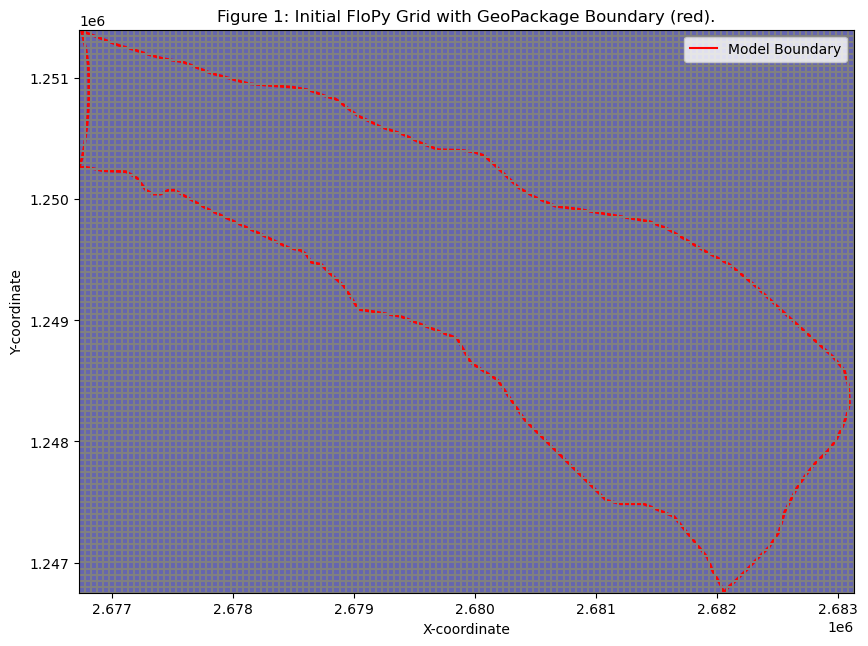

Total number of cells in the grid: 11904
Total number of active cells in the grid: 4146


/Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/../SUPPORT_REPO/src/grid_utils.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return gdf.geometry.unary_union


In [6]:
# Goal: visually check extent, rotation, and active cells. 
# Inputs: 
# - modelgrid
# - gdf
# Plots: Boundary and grid overlay. 
# No side effects in this cell.

# Plotting the grid 
fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # Adjusted figsize to be more square if needed
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax) # Pass ax directly
pc = pmv.plot_array(modelgrid.top, alpha=0.5, cmap='terrain') # Added cmap for better visualization
pmv.plot_grid()

# Plot the GeoPackage boundary on top for verification
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
# Add a legend for the boundary
boundary_legend = mlines.Line2D([], [], color='red', label='Model Boundary')
ax.legend(handles=[boundary_legend], loc='upper right')

ax.set_title("Figure 1: Initial FloPy Grid with GeoPackage Boundary (red).")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

# Build grid polygons, tag active cells (≥50% inside), and get IBOUND
grid_gdf, ibound = build_grid_gdf_and_ibound(
    modelgrid=modelgrid,
    boundary_gdf=gdf,        # your boundary GeoDataFrame
    frac_threshold=0.5,      # change if needed
    nlay=nlay                 # use your model's nlay
)

# Count the number of cells in the grid
total_cells = ncol * nrow * nlay
print(f"Total number of cells in the grid: {total_cells}")

# Count the number of active cells
active_cells = ibound[ibound > 0].sum()
print(f"Total number of active cells in the grid: {active_cells}")

Congratulation! You have successfully set up your first model grid and display it in Figure 1. The grid is a fundamental part of the model, as it defines the spatial resolution and extent of the simulation.  

You will notice, that the main flow direction is diagonal to the cells orientation. There are a few reasons why this is sub-optimal: 

1. A diagonal flow direction can lead to *numerical dispersion* and other artifacts in the simulation results. As you might know from other lectures, the finite-difference method used in MODFLOW, calculates flow across the faces of the grid cells. It cannot directly compute flow diagonally across a single cell. Instead, it approximates a diagonal path as a series or orthogonal, "stair-step" movements from one cell to the next. We therefore try to allign the x-axis of the model grid along the main flow direction of a groundwater body. 
2. We also try to align the grid with major hydrogeological features and boundaries to avoid creating jagged, "stair-step" boundaries.
3. Because Modflow2005 only includes active model cells (inside the model boundary) in the simulation, the number of active model cells matters. It is the most important factor in the model design that determines the computational speed of the simulation. 

#### 2.1.3 Typically necessary iterations 
Creating a model grid is rarely a one-shot process. After the first attempt, visualization often reveals mismatches that require adjustment. Common iterations include:

- Rotation and alignment – adjusting the grid angle so that rows/columns follow the main axis of the model domain (e.g., a river valley).  
- Extent and origin – shifting or expanding the grid so the boundary fits cleanly within the grid cells.  
- Cell size – refining or coarsening resolution to balance accuracy with computational cost.

Such iterations are a normal part of model development. We visualize, adjust parameters, and regenerate the grid until it represents the case study domain well enough for the next steps. Here, we demonstrate one such iteration: rotating the grid to better align with the flow direction and buffering the model boundary to ensure full coverage.

##### Grid Rotation and Buffering
We rotate the model grid to align it with the model boundary. We will also buffer the model boundary to ensure that the grid cells cover the entire area of interest. The easiest way to do that are by following the steps below, each step is accompanied by visual checks: 
1. Rotate the model boundary polygon to align with the main flow direction and major hydrogeological features. 
2. Buffer the rotated model boundary polygon to ensure that the grid cells cover the entire area of interest.
3. Create a new grid based on the buffered polygon and apply the rotation to the structured grid.

We start with the rotation of the model boundary polygon. It should be rotated to minimize the number of grid cells outside the model boundary. Optimally, the grid cells should be aligned with the main flow direction.  

The rotation angle (variable `grid_rotation_angle` in code below) can be adjusted by trial and error to find the best fit.

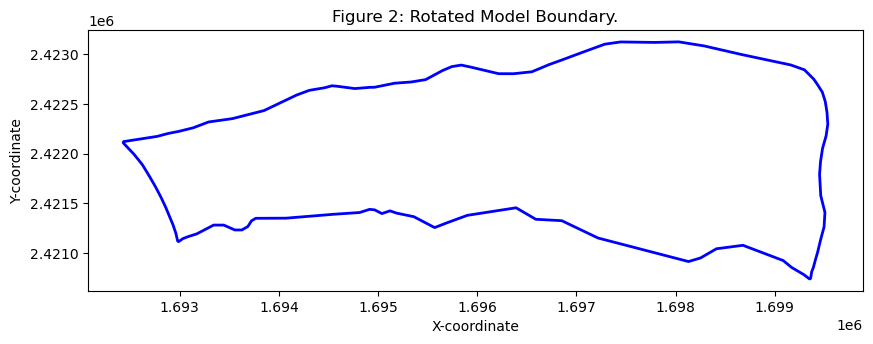

In [7]:
# --- 1. Rotation of the model boundary --- 
# To generate a rotated grid in FloPy, the easiest way is to create a regular 
# grid and then apply a rotation transformation to it. 
# We first rotate the model boundary polygon to the desired angle. From there, 
# we can create a regular grid and then apply the rotation to the grid in the 
# structured grid object.
# This approach allows us to maintain the integrity of the grid while applying
# the desired rotation.
# Every step includes visual checks.

# Buffer the model boundary gdf
gdf['geometry'] = gdf['geometry'].buffer(10)

# Define the rotation angle in degrees
grid_rotation_angle = 30  # degrees, identified by trial and error, you can adjust this angle to minimize the number of cells outside the boundary
origin_rotation = Point(0, 0)  # Origin for rotation, can be adjusted as needed
# Rotate the model boundary polygon
gdf_rotated = gdf.copy()

gdf_rotated['geometry'] = gdf_rotated['geometry'].apply(
    lambda geom: rotate(geom, grid_rotation_angle, origin=origin_rotation)
)
# Get the bounding box of the rotated geometry
xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated = gdf_rotated.total_bounds
# Plot the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_rotated.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
ax.set_title("Figure 2: Rotated Model Boundary.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

Figure 2 shows the rotated model boundary. An angle of 30 degrees seems to be suitable for the Limmat Valley model. In the next step, we will create a new grid based on this rotated model boundary (see Figure 3).

Original Grid: 128 columns, 93 rows
Rotated Grid: 142 columns, 48 rows


Text(0.5, 1.0, 'Figure 3: Rotated FloPy Grid with Rotated Boundary.')

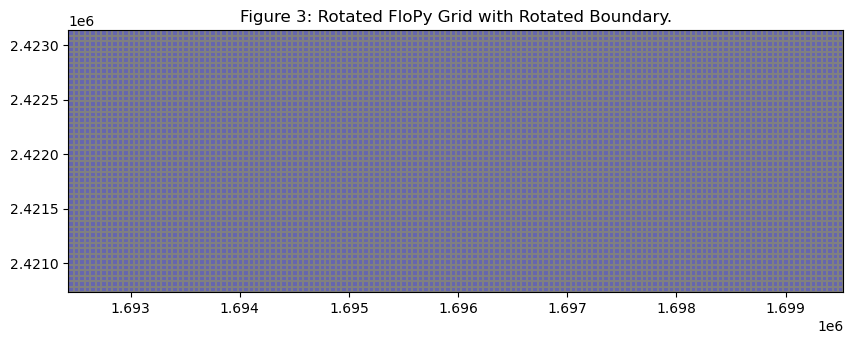

In [8]:
# --- 2. Creation of a new Model Grid based on the rotated Model Boundary ---
# We now have new bounding box coordinates for the rotated model boundary. 
# These we need to rotate back to the original coordinate system to create a
# regular grid that fits the rotated boundary.
# We use the rotated bounding box to define the grid dimensions.
# Calculate the new grid dimensions based on the rotated bounding box
width_rotated = xmax_rotated - xmin_rotated
height_rotated = ymax_rotated - ymin_rotated

# Calculate the number of rows and columns based on the rotated bounding box
ncol_rotated = int(np.ceil(width_rotated / cell_size)) - 1 # Based on visual inspection of rotated grid.
nrow_rotated = int(np.ceil(height_rotated / cell_size))

# Compare number of rows and columns with the original grid
print(f"Original Grid: {ncol} columns, {nrow} rows")
print(f"Rotated Grid: {ncol_rotated} columns, {nrow_rotated} rows")

# Define the delr and delc for the rotated grid
delr_rotated = np.full(ncol_rotated, cell_size)
delc_rotated = np.full(nrow_rotated, cell_size) 

# Plot the rotated grid and the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create a new StructuredGrid with the rotated dimensions
rotated_grid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=np.ones((nrow_rotated, ncol_rotated)) * 100,  # Example top elevation
    botm=np.ones((nlay, nrow_rotated, ncol_rotated)) * 50,  # Example bottom elevation
    xoff=xmin_rotated,  # Use the lower-left of the rotated extent
    yoff=ymin_rotated,  # Use the lower-left of the rotated extent
    angrot=0,  # We are currently in the rotated coordinate system, so no additional rotation is needed
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf_rotated.crs.to_string()  # Automatically get CRS from geopackage
)
pmv = flopy.plot.PlotMapView(modelgrid=rotated_grid, ax=ax)
pc = pmv.plot_array(rotated_grid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
ax.set_title("Figure 3: Rotated FloPy Grid with Rotated Boundary.")

Original coordinates after inverse rotation:
xmin: 2676055.63, ymin: 1250203.89
xmax: 2683404.68, ymax: 1248721.21
Corrected grid lower-left corner:
xll = 2676055.63
yll = 1250203.89
Number of cells in the rotated grid: 6816
Number of cells in the original grid: 11904
The rotated grid has 43 % less cells than the initial grid.


/Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/../SUPPORT_REPO/src/grid_utils.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return gdf.geometry.unary_union


Total number of active cells in the grid: 4223
Model grid created with the following parameters:
xll:2676055.6265532523; yll:1250203.8923757293; rotation:-30; crs:EPSG:2056; units:meters; lenuni:2


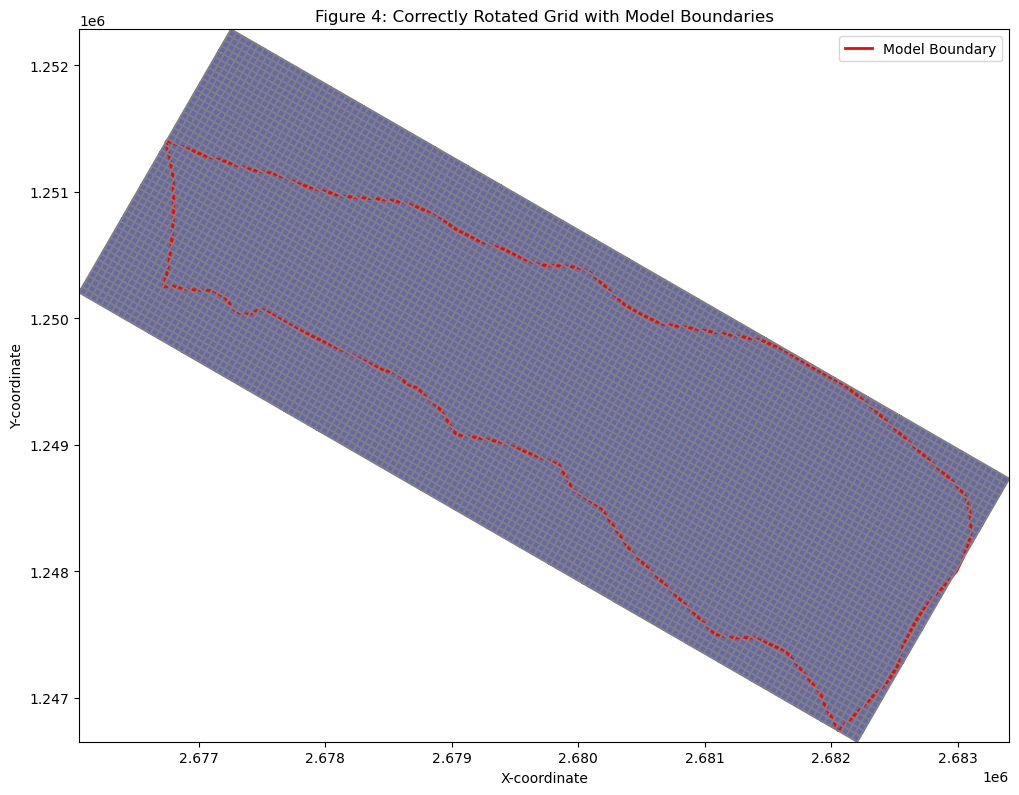

In [9]:
# --- 3. Rotation of the new Model Grid in the CH Coordinate System ---
# Now we need to rotate the lower-left corner of the rotated grid back to the 
# original coordinate system.
# The lower-left corner of the rotated bounding box
# Create points from the rotated bounding box coordinates
min_point_rotated = Point(xmin_rotated, ymin_rotated)
max_point_rotated = Point(xmax_rotated, ymax_rotated)

# Apply inverse rotation (negative angle) around the same origin
min_point_original = rotate(min_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)
max_point_original = rotate(max_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)

# Extract the coordinates
xmin_original = min_point_original.x
ymin_original = min_point_original.y
xmax_original = max_point_original.x
ymax_original = max_point_original.y

print(f"Original coordinates after inverse rotation:")
print(f"xmin: {xmin_original:.2f}, ymin: {ymin_original:.2f}")
print(f"xmax: {xmax_original:.2f}, ymax: {ymax_original:.2f}")

xll = xmin_original
yll = ymin_original

print(f"Corrected grid lower-left corner:")
print(f"xll = {xll:.2f}")
print(f"yll = {yll:.2f}")
print(f"Number of cells in the rotated grid: {nrow_rotated * ncol_rotated * nlay}")
print(f"Number of cells in the original grid: {nrow * ncol * nlay}")
print(f"The rotated grid has {round(((nrow * ncol * nlay) - (nrow_rotated * ncol_rotated * nlay))/(nrow * ncol * nlay)*100)} % less cells than the initial grid.")

# Update the top and bottom elevation arrays
# For simplicity, we keep the dummy elevations. They are reset later.
top = np.ones((nrow_rotated, ncol_rotated)) * 100  # Example top elevation
botm = np.ones((nlay, nrow_rotated, ncol_rotated)) * 50  # Example bottom elevation

# Create the FloPy structured grid with the rotated bounding box
modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=top,
    botm=botm,
    xoff=xmin_original,  # Use the lower-left of the rotated extent
    yoff=ymin_original,  # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle,  # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string()  # Automatically get CRS from geopackage
)

# Update grid polygons, tag active cells (≥50% inside), and get IBOUND
grid_gdf, ibound = build_grid_gdf_and_ibound(
    modelgrid=modelgrid,
    boundary_gdf=gdf,        # your boundary GeoDataFrame
    frac_threshold=0.5,      # change if needed
    nlay=nlay                 # use your model's nlay
)
# Count the number of active cells
active_cells = ibound[ibound > 0].sum()
print(f"Total number of active cells in the grid: {active_cells}")

print("Model grid created with the following parameters:")
print(modelgrid)
# Add the modelgrid to the MODFLOW model
mf.modelgrid = modelgrid

# Plot the rotated grid and the model_boundary to check alignment
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
pc = pmv.plot_array(mf.modelgrid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid() 

gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line], loc='upper right')
ax.set_title("Figure 4: Correctly Rotated Grid with Model Boundaries")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

After rotating the grid, the number of cells increases slightly because the rotated extent no longer fits as tightly around the model boundary. We accept this trade-off, since aligning the grid with the main groundwater flow direction reduces numerical dispersion and improves the accuracy of simulated flow paths.

You might wonder why we care about numerical dispersion, given the large uncertainties involved in groundwater flow modelling. Even though groundwater flow models involve many uncertainties (hydraulic properties, recharge estimates, boundary conditions), we still want to minimize numerical errors such as numerical dispersion. The reason is simple: uncertainties are part of the real system and can be reduced with better data or calibration, but numerical errors are artificial and only come from how we discretize and solve the equations.

Numerical dispersion can smear sharp flow patterns, mix solutes unrealistically, or dampen hydraulic gradients. If we can reduce this error (e.g., by aligning the grid with the main flow direction), the model output better reflects the true hydrogeological processes, and we can focus on the real uncertainties that matter for decision-making.


#### 2.1.4 Save model grid for external use
Let's export the model grid to a shapefile in case we want to use it for visualizations outside flopy. Visualizing it in a different context, e.g. in QGIS, is a good sanity check. This will help us to verify that the grid is correctly aligned with the model boundary and that the cells are not too large or too small (see Figure 5).

In [10]:
# Export the model grid to shapefile
# Create a list to store grid cell polygons
grid_cells = []

# Get grid cell vertices using FloPy's grid functionality
for i in range(modelgrid.nrow):
    for j in range(modelgrid.ncol):
        # Get cell vertices
        cell_vertices = modelgrid.get_cell_vertices(i, j)
        
        # Create polygon from vertices
        cell_polygon = Polygon(cell_vertices)
        
        # Store cell information
        grid_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': cell_polygon,
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })

# Create GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_cells, crs=modelgrid.crs)

# Export to GeoPackage
grid_geopackage_path = os.path.join(workspace, 'model_grid.gpkg')
grid_gdf.to_file(grid_geopackage_path, driver='GPKG', layer='model_grid')

print(f"Model grid exported to: {grid_geopackage_path}")

Model grid exported to: /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model/model_grid.gpkg


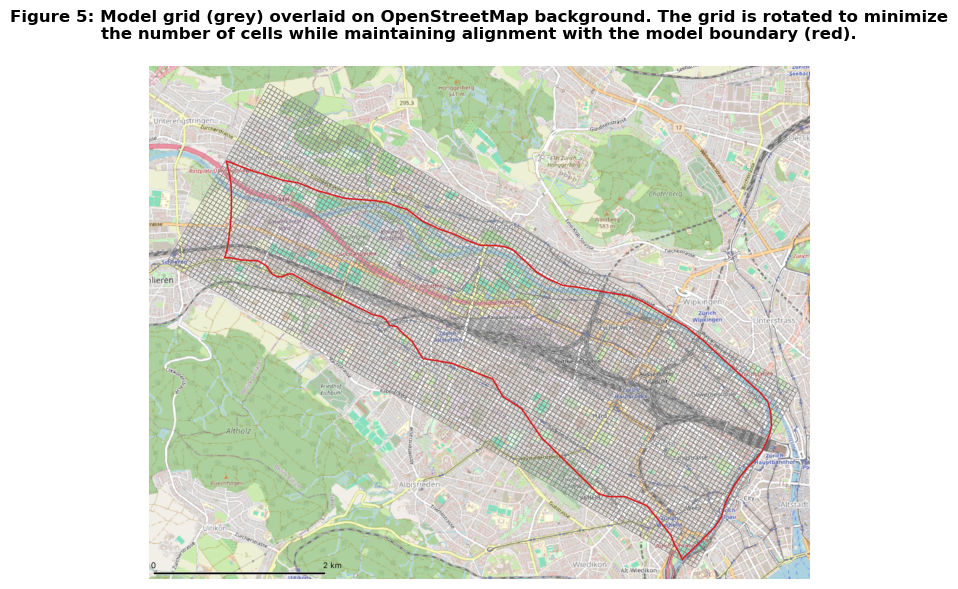

In [11]:
display_image(
    image_filename='model_grid_on_openstreetmap.png', 
    image_folder='4_model_implementation',
    caption='Figure 5: Model grid (grey) overlaid on OpenStreetMap background. The grid is rotated to minimize the number of cells while maintaining alignment with the model boundary (red). '
)

We now have a regular grid that fits the rotated boundary. The grid is defined by its origin, the number of rows and columns, and the cell size. The grid is a fundamental part of the model, as it defines the spatial resolution and extent of the simulation. 


> **Optional Challenge:**   
> Try to find a better rotation angle by adjusting the `grid_rotation_angle` variable in the code above. You can also try to change the `cell_size` to see how it affects the number of cells inside the model boundary.

In [12]:
create_nested_step_completion_marker(2, 1)

Checkbox(value=False, description='✅ Yes, I have completed Step 2.1: Discretization - Grid Creation', indent=F…

Output()

### 2.2 Model Top
Now that we have the model grid, let's define the top of the model. The top of the model will be defined by the DEM, which we will use to create a single layer model. 

#### 2.2.1 Data processing: Resample DEM to model grid
We derive the model top elevation from the DEM. These are the steps to achieve this:

1. Resample the DEM to the model grid.
2. Extract the elevation values at the model grid locations.
3. Assign these values to the model top layer.

Let's have a look at our DEM in the model area (Figure 6). 

dem_converted_bbox.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
dem_converted_bbox_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.


Text(0.5, 1.0, 'Figure 6: DEM in original resolution in the model area.')

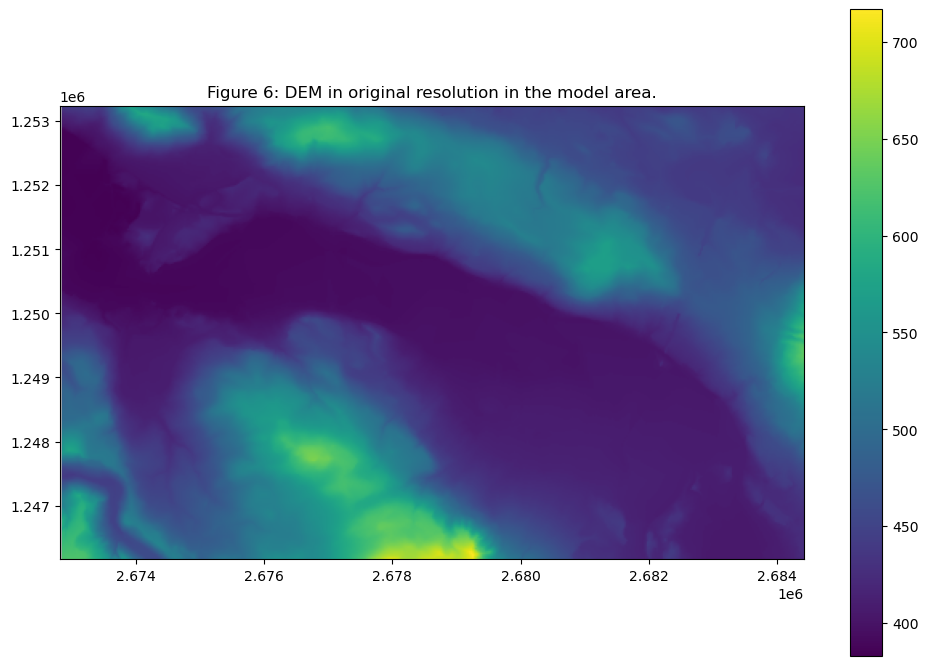

In [13]:
# --- 1. Inspect the DEM ---
# Get the DEM data from the server
dem_path = download_named_file(
    name='dem',
    data_type='gis'
)

# Load it into object rio
rio = Raster.load(dem_path)

# Get the DEM array and its valid index
arr = rio.get_array(1)
idx = np.isfinite(arr)

# Get the min and max values for plotting
vmin, vmax = arr[idx].min(), arr[idx].max()

# Plot the DEM
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax = rio.plot(ax=ax, vmin=vmin, vmax=vmax)
plt.colorbar(ax.images[0], shrink=0.7)
# pmv.plot_grid(ax=ax, lw=0.5, color="white")
ax.set_title("Figure 6: DEM in original resolution in the model area.")


The resolution of the DEM does not match the model grid resolution, so we will resample the DEM to fit the model grid. We will use the `rio.resample_to_grid` function to resample the DEM to the model grid resolution. This will create a new raster that matches the model grid resolution and can be used as the model top (Figure 7).

Text(0.5, 1.0, 'Figure 7: Resampled DEM on Model Grid with Buffered Model Boundary')

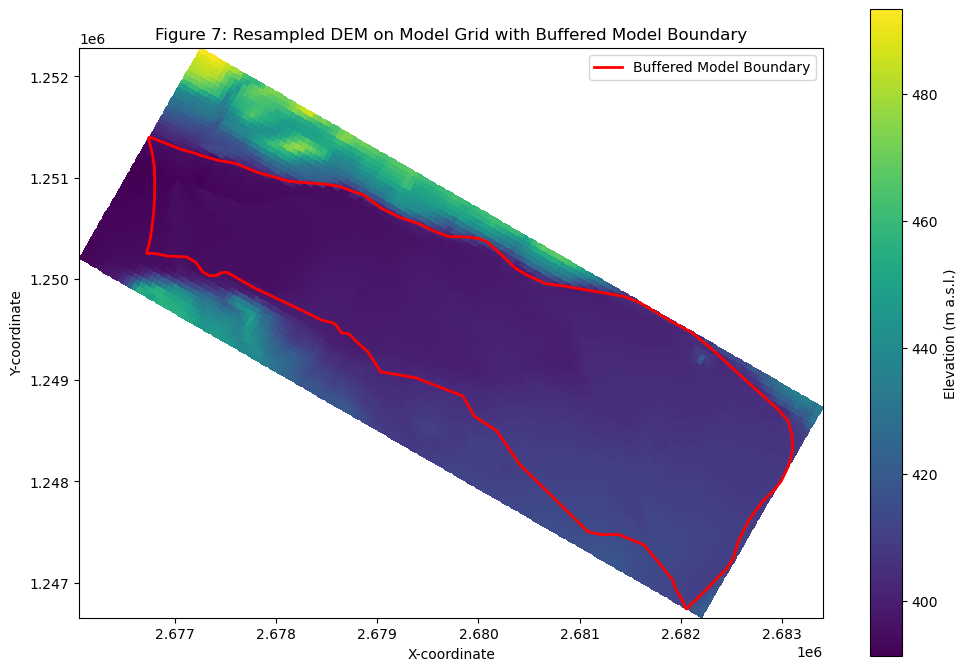

In [14]:
# --- 2. Resample the DEM ---
# Depending on the resolution of the DEM, resampling can be computationally 
# intensive.
t0 = time.time() # To log the time it takes to resample the DEM
model_top = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# We round to 10 centimeters to avoid having to store too many digits
model_top = np.round(model_top, 1)

# Update vmin and vmax based on the resampled data
vmin, vmax = model_top.min(), model_top.max()

# Now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_top, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)

# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 7: Resampled DEM on Model Grid with Buffered Model Boundary")

In [15]:
# (Optional) Save the model top layer to a file for later use
# This step makes sense if resampling is slow. Instead of repeating the 
# resampling every time you run the notebook, you can just load the
# precomputed file.
top_file_path = os.path.join(workspace, 'model_top.npy')
np.save(top_file_path, model_top)

In [16]:
create_nested_step_completion_marker(2, 2)

Checkbox(value=False, description='✅ Yes, I have completed Step 2.2: Discretization - Model Top (DEM Resamplin…

Output()

### 2.3 Model Bottom

Next we tackle the bottom layer. The groundwater map of the canton of Zurich shows contour lines of the thickness of the aquifer for the deeper zones but for the shallower zones we see the range of the aquifer thickness. We calculate the bottom of the model by subtracting the aquifer thickness from the model top. 

$$ \text{Bottom of the model} = \text{Top of the model} - \text{Aquifer thickness}$$

We'll walk you through the steps to create the bottom layer of the model in the following code cells.

#### 2.3.1 Data processing: Interpolate aquifer thickness to model grid
We'll start by displaying the contours of aquifer thickness in the model area (Figure 8). This will help us visualize the aquifer thickness and understand how it varies across the model area. Please note that the aquifer thickness is very thin in parts of the model area. Cells in this region may run dry during the simulation, which is a common occurrence in groundwater models of shallow unconfined aquifers. By default, cells that run dry become impermeable in modflow but we can set rewetting parameters which allow the model to iteratively re-activate dry cells. This can, however, lead to numerical instability. We'll have to keep an eye on this during the simulation and adjust the model parameters for re-wetting if necessary. 

A summary of the steps:
1. Visualize the aquifer thickness contours.
2. Interpolate the aquifer thickness to the model grid.
3. Subtract the aquifer thickness from the model top to obtain the model bottom.

Grundwasservorkommen_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Grundwasservorkommen_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.


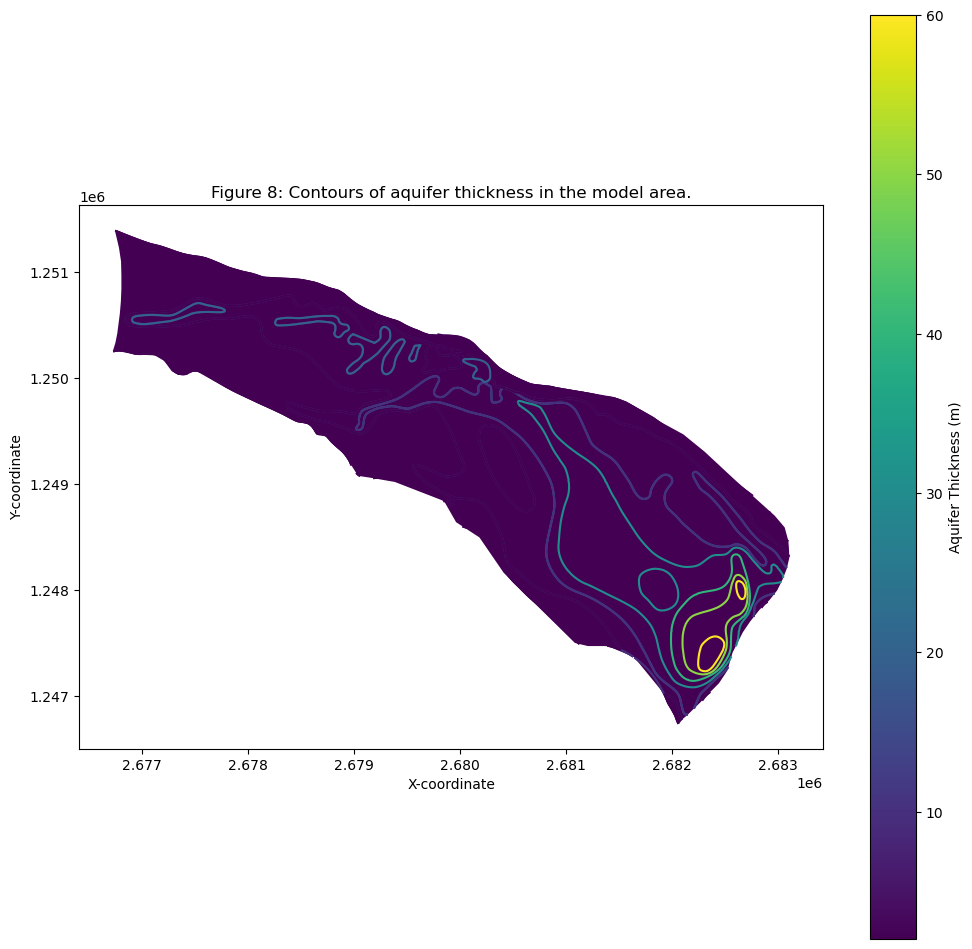

In [17]:
# --- 1. Visualize available aquifer bottom data ---
# Load the polygon layers with information about aquifer thickness.
gw_map_path = download_named_file(
    name='groundwater_map_norm', 
    data_type='gis', 
)

deep_contours_gdf = gpd.read_file(gw_map_path, layer="GS_GW_MAECHTIGKEIT_L")
shallow_gdf = gpd.read_file(gw_map_path, layer="GS_GW_LEITER_F") 

# Reproject the GeoDataFrames to match the model grid CRS
deep_contours_gdf = deep_contours_gdf.to_crs(modelgrid.crs)
shallow_gdf = shallow_gdf.to_crs(modelgrid.crs)

# For the deep contours, the aquifer thickness in meters is in the field 
# "LABEL". For the shallow contours, we have the field "GWLTYP" which corresponds 
# to a range of aquifer thickness. We have to manually assign a label attribute 
# here, using the GIS-Broswer as reference. 
# type_labels maps GWLTYP to the corresponding aquifer thickness in meters.
type_labels = {
        1: 2, 
        2: 2,
        4: 10,
        6: 20,
    }
# Create a new column 'aquifer_thickness' in shallow_gdf
shallow_gdf['aquifer_thickness'] = shallow_gdf['GWLTYP'].map(type_labels)

# Create a new column 'aquifer_thickness' in deep_contours_gdf
deep_contours_gdf['aquifer_thickness'] = deep_contours_gdf['LABEL'].astype(float)

# Discard rows in the shallow_gdf where aquifer_thickness is NaN
shallow_gdf = shallow_gdf.dropna(subset=['aquifer_thickness'])

# Now we need to make sure all shapes are available as lines. 
# Convert shallow polygons to contour lines by taking their boundaries
shallow_contours_gdf = shallow_gdf.copy()
shallow_contours_gdf.geometry = shallow_contours_gdf.geometry.boundary

# Define the buffered model boundary as a contour with 2m thickness
boundary_contour_gdf = gdf.copy()
boundary_contour_gdf['aquifer_thickness'] = 2.0

# View the first few rows of the deep contours and shallow contours
# print("Deep contours (aquifer thickness in meters):")
# print(deep_contours_gdf[['LABEL', 'aquifer_thickness']].head())
# print("\nShallow contours (aquifer thickness in meters):")
# print(shallow_gdf[['GWLTYP', 'aquifer_thickness']].head())

# Combine all contour dataframes into one
# We select only the 'aquifer_thickness' and 'geometry' columns to ensure consistency
all_contours_gdf = gpd.GeoDataFrame(
    pd.concat([
        deep_contours_gdf[['aquifer_thickness', 'geometry']],
        shallow_contours_gdf[['aquifer_thickness', 'geometry']],
        boundary_contour_gdf[['aquifer_thickness', 'geometry']]
    ], ignore_index=True),
    crs=gdf.crs
)

# Clip the contours to the model boundary polygon
clipped_gdf = gpd.clip(all_contours_gdf, gdf)

# Now we can plot the combined contours
fig, ax = plt.subplots(figsize=(12, 12))
clipped_gdf.plot(ax=ax, column='aquifer_thickness', cmap='viridis',
                 legend=True, legend_kwds={'label': "Aquifer Thickness (m)"})
ax.set_title("Figure 8: Contours of aquifer thickness in the model area.")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

Now we need to subtract the aquifer thickness from the top of the model to define the bottom of the model. 

For this, we interpolate the contour lines of the aquifer thickness to the model grid (Figure 9). This will create a new raster that matches the model grid resolution which we can subtract from the top of the model to obtain the bottom elevation (Figure 10).

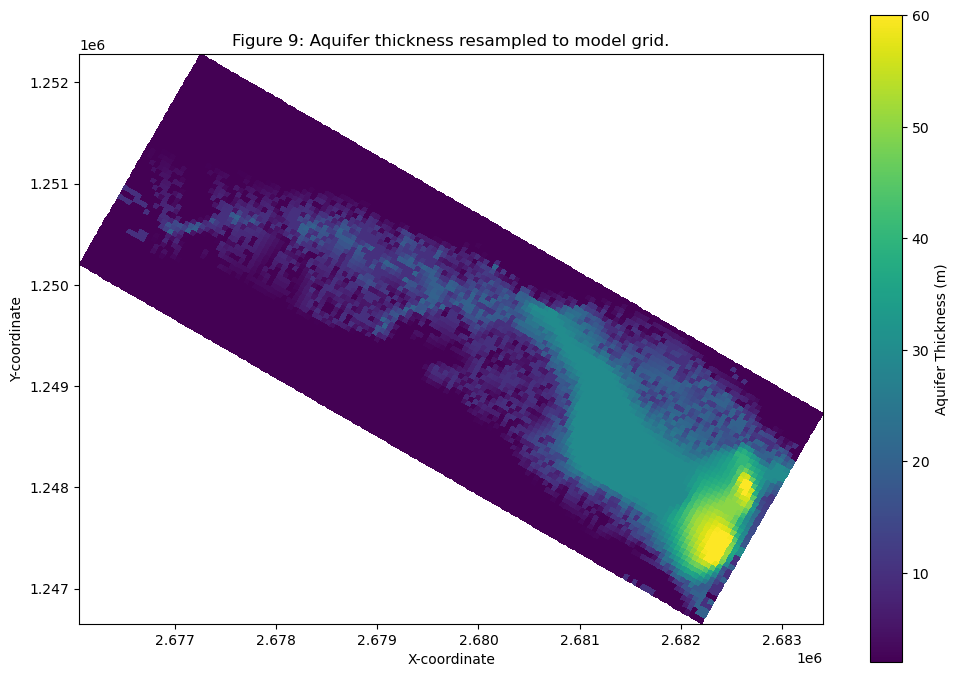

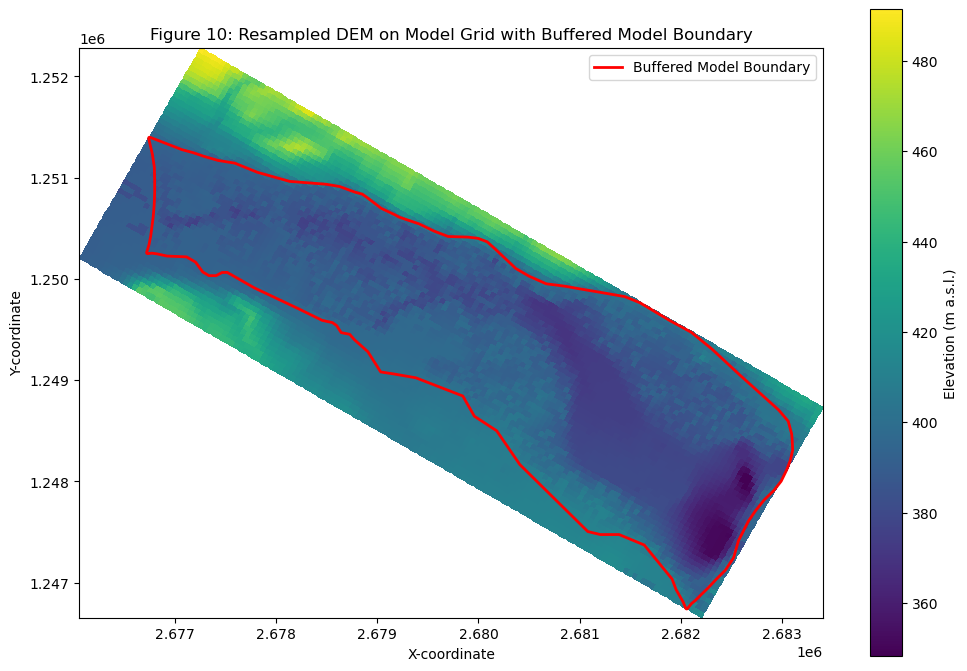

In [18]:
# --- 2. Interpolate the aquifer thickness on the model grid and calculate 
# aquifer thickness

# ---    Interpolate aquifer thickness to model grid ---
# Extract all points from the combined contour lines for interpolation
points_for_interp = []
for idx, row in clipped_gdf.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    if row.geometry.geom_type == 'MultiLineString':
        for line in row.geometry.geoms:
            for x, y in line.coords:
                points_for_interp.append((x, y, row['aquifer_thickness']))
    elif row.geometry.geom_type == 'LineString':
        for x, y in row.geometry.coords:
            points_for_interp.append((x, y, row['aquifer_thickness']))

points_for_interp = np.array(points_for_interp)

# --- PLOT: Points for Interpolation of Aquifer Thickness on Model Grid ---
# Uncomment the following lines to visualize the points used for interpolation
# fig, ax = plt.subplots(figsize=(12, 12))
# sc = ax.scatter(points_for_interp[:, 0], points_for_interp[:, 1], c=points_for_interp[:, 2], cmap='viridis', s=5)
# plt.colorbar(sc, label='Aquifer Thickness (m)')
# ax.set_title("Step 1. Points from All Contours for Interpolation")
# ax.set_xlabel("X-coordinate")
# ax.set_ylabel("Y-coordinate")
# ax.set_aspect('equal', adjustable='box')
# plt.show()

# Interpolate directly onto the model grid cell centers
grid_x, grid_y = modelgrid.xcellcenters, modelgrid.ycellcenters

# First, use linear interpolation. This creates a smooth surface between contours.
aquifer_thickness_linear = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x, grid_y), 
    method='linear'
)

# Linear interpolation leaves NaNs outside the convex hull of the data.
# Second, fill these NaNs using nearest neighbor interpolation to cover the whole grid.
nan_indices = np.isnan(aquifer_thickness_linear)
aquifer_thickness_resampled = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x[nan_indices], grid_y[nan_indices]), 
    method='nearest'
)
aquifer_thickness_linear[nan_indices] = aquifer_thickness_resampled

# The final resampled grid
aquifer_thickness_resampled = aquifer_thickness_linear

# Save aquifer thickness to a file for later use
aquifer_thickness_file_path = os.path.join(workspace, 'aquifer_thickness.npy')
np.save(aquifer_thickness_file_path, aquifer_thickness_resampled)

# --- PLOT: Resampled Grid on Model Grid ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(aquifer_thickness_resampled)
plt.colorbar(im, shrink=0.7, label="Aquifer Thickness (m)")
ax.set_title("Figure 9: Aquifer thickness resampled to model grid.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

# --- 3. Calculate the aquifer bottom ---
# Subtract the aquifer thickness from the top of the model to define the bottom
model_bottom = model_top - aquifer_thickness_resampled

# Ensure the model bottom is a 3d array (nlay, nrow_rotated, ncol_rotated)
if model_bottom.ndim == 2:
    model_bottom = model_bottom[np.newaxis, :, :]  # Add a new axis for layers

# --- PLOT: Final Aquifer Bottom ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_bottom, vmin=np.nanmin(model_bottom), 
                    vmax=np.nanmax(model_bottom))
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
ax.set_title("Figure 10: Final aquifer bottom elevation. ")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 10: Resampled DEM on Model Grid with Buffered Model Boundary")

plt.show()

#### 2.3.2 Visual check
Now we update the structured grid object by replacing the dummy model top in the model object with our resampled DEM. This will ensure that the model top reflects the actual topography of the Limmat Valley. We visualize the final model grid with the top elevation (Figure 11) for verification.  

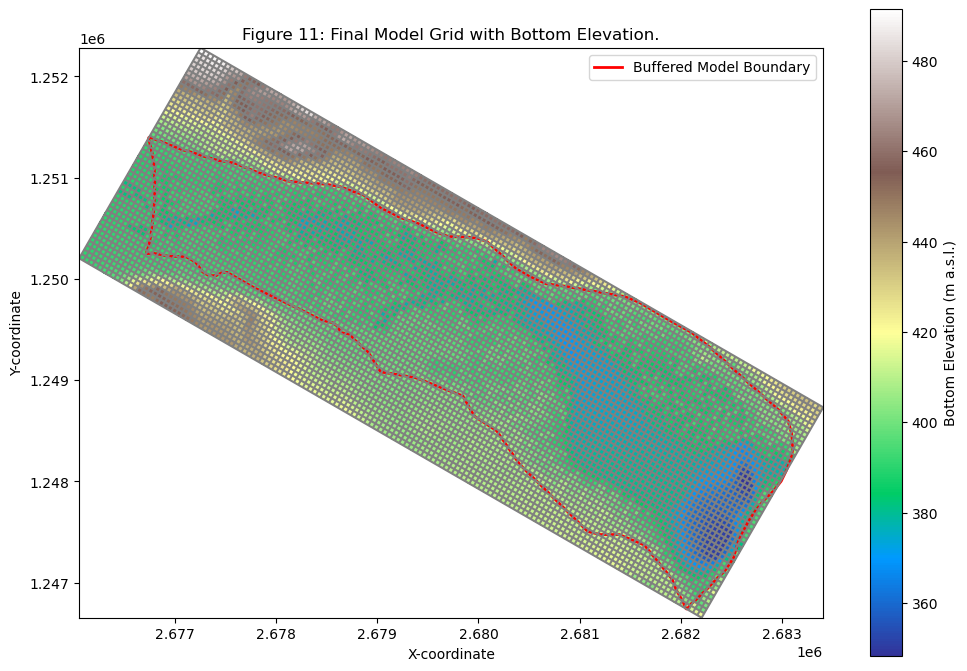

In [19]:
# Add new model top and bottom to the modelgrid
modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    xoff=xmin_original, # Use the lower-left of the rotated extent
    yoff=ymin_original, # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle, # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)

# Update the modelgrid in the MODFLOW model
mf.modelgrid = modelgrid

# Plot the mf modelgrid to verify
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_array(mf.modelgrid.botm, vmin=np.nanmin(mf.modelgrid.botm), 
                    vmax=np.nanmax(mf.modelgrid.botm), cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Bottom Elevation (m a.s.l.)")
pmv.plot_grid()
# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])

ax.set_aspect('equal', adjustable='box')
ax.set_title("Figure 11: Final Model Grid with Bottom Elevation.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

In [20]:
create_nested_step_completion_marker(2, 3)

Checkbox(value=False, description='✅ Yes, I have completed Step 2.3: Discretization - Aquifer Thickness & Bott…

Output()

#### 2.4 Write the model geometry to DIS package
Finally we save the model grid to the DIS package of our model. Please note that when defining the DIS package, we can also pass the temporal discretization parameters directly to the DIS package constructor (see code snippet below). We will start out with a steady state simulation, so we only need one stress period. If you have transient data, you would define multiple stress periods. 

In [21]:
# Temporal discretization
# We start out with a steady state simulation, so we only need one stress period.
# If you have transient data, you would define multiple stress periods.
# Here, we define a single stress period with a length of 1 day.
# Please note that we hereby implicitly define the time unit of our model to be 
# days. We will need to be consistent with this throughout the model setup. 
nper = 1  # Number of stress periods
perlen = [1.0]  # Length of each stress period in days
nstp = [1]  # Number of time steps in each stress period (1 for steady state)
tsmult = [1.0]  # Time step multiplier (1.0 for steady state)
steady = [True]  # Steady state flag for each stress period

# Add re-wetting parameters
# These parameters are used to control the re-wetting of cells in the model.
# They are not strictly necessary for a basic model, but can be useful for 
# more complex models with transient conditions.
wetdry = 0.2  # Wetting threshold (fraction of cell thickness)
hclose = 1e-5  # Head closure criterion (m)
rclose = 1e-5  # Residual closure criterion (m)

# Explicitly pass the grid parameters to the DIS package constructor.
# This will correctly set the nrow, ncol, etc. on the mf object.
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top,
    botm=model_bottom,
    xoff=xmin_original,
    yoff=ymin_original,
    angrot=-grid_rotation_angle,
    lenuni=2,
    crs=gdf.crs.to_string(),  # Automatically get CRS from geopackage
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady
)

# Save the model grid to a file for later use
grid_file_path = os.path.join(workspace, 'model_grid.pkl')
with open(grid_file_path, 'wb') as f:
    pickle.dump(modelgrid, f) 

In [22]:
create_nested_step_completion_marker(2, 4)

Checkbox(value=False, description='✅ Yes, I have completed Step 2.4: Discretization - Writing DIS Package', in…

Output()

## 3 Parameterization
The discretized groundwater flow equation contains several parameters that need to be defined for the model. We use the layer-property flow package to specify these parameters.

### 3.1 Layer-Property Flow (LPF) Package

The Layer-Property Flow (LPF) Package is where we specify the hydraulic properties of the aquifer. These properties determine how easily water moves through the subsurface and how the aquifer stores and releases water.

- **Hydraulic Conductivity (K)**: Since we don’t have site-specific measurements, we will begin with a uniform value of 10 m/d, which is typical for gravel aquifers (see Notebook 2). Later, during model calibration, we may divide the model into zones with different values of K to better represent aquifer heterogeneity.  
- **Storage Properties**: For this first version of the model, we assume uniform values:
    - Specific storage (Ss): $1 \times 10^{-4} \, \text{m}^{-1}$ (represents elastic storage, important in confined conditions).  
    - Specific yield (Sy): 0.15 (represents drainable porosity, dominant in unconfined conditions).  
- **Hydraulic Conductivity Field**: With these settings, the model currently uses a single uniform conductivity field (Figure 13).  
- **Wetting Parameters**: The LPF package also contains options for wetting parameters, which control how model cells that become dry can re-wet during transient simulations. For simple steady-state or basic transient models these are not strictly necessary, but they become important in more advanced models that include significant water table fluctuations.  


Setting up Layer Properties (LPF) Package with uniform values...

LPF package created successfully with uniform properties:
Horizontal hydraulic conductivity: 10.0 m/day
Vertical hydraulic conductivity: 1.0 m/day
Specific yield: 0.15
Specific storage: 0.0001 1/m
Layer type: Convertible (unconfined)


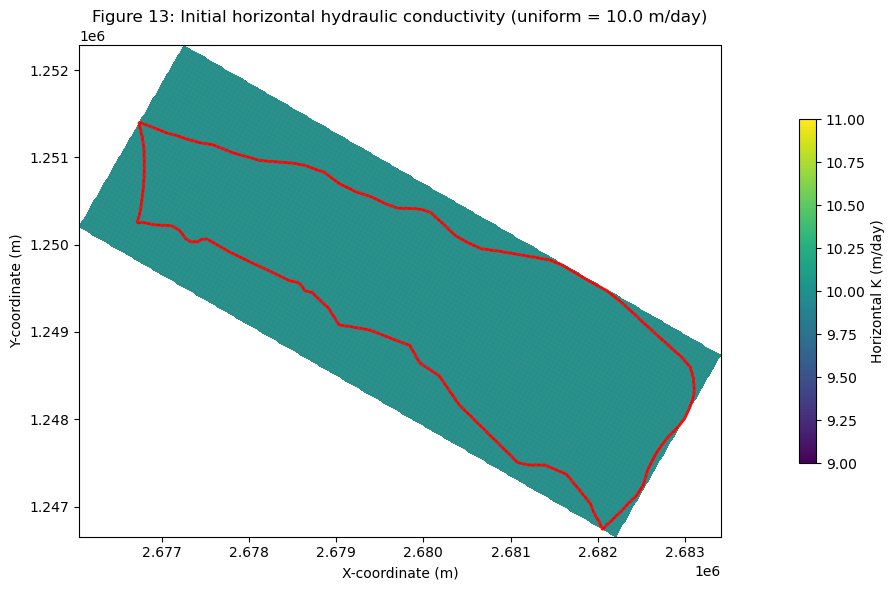


Uniform K fields saved to /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model


In [23]:
print("Setting up Layer Properties (LPF) Package with uniform values...")

# Uniform hydraulic conductivity values
# Typical for sandy gravel aquifers in Swiss valleys
hk_uniform = 10.0  # m/day - horizontal hydraulic conductivity
vk_uniform = 1.0   # m/day - vertical hydraulic conductivity (typically Kh/10)

# Create uniform K arrays
hk = np.ones((nlay, nrow_rotated, ncol_rotated)) * hk_uniform
vk = np.ones((nlay, nrow_rotated, ncol_rotated)) * vk_uniform

# Storage properties (uniform)
sy = 0.15  # Specific yield (typical for unconfined sandy gravel aquifers)
ss = 1e-4  # Specific storage (1/m) (typical value)

# Layer type (0 = confined, 1 = convertible/unconfined)
# Limmat valley aquifer is unconfined
laytyp = 1

# Create the LPF package
lpf = flopy.modflow.ModflowLpf(
    mf,
    hk=hk,                  # Horizontal hydraulic conductivity
    vka=vk,                 # Vertical hydraulic conductivity
    sy=sy,                  # Specific yield
    ss=ss,                  # Specific storage
    laytyp=laytyp,          # Layer type (1 = convertible/unconfined)
    ipakcb=53,              # Unit number for cell-by-cell budget file
    hdry=-999.99,           # Head assigned to dry cells
    wetfct=0.1,             # Wetting factor
    iwetit=1,               # Wetting iteration interval
    laywet=1                # Flag indicating if wetting is active for each layer
)

print("\nLPF package created successfully with uniform properties:")
print(f"Horizontal hydraulic conductivity: {hk_uniform} m/day")
print(f"Vertical hydraulic conductivity: {vk_uniform} m/day")
print(f"Specific yield: {sy}")
print(f"Specific storage: {ss} 1/m")
print(f"Layer type: {'Convertible (unconfined)' if laytyp == 1 else 'Confined'}")

# Quick visualization of the uniform K field
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Plot horizontal K
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(hk[0], masked_values=[0])
#pmv1.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
cb1 = plt.colorbar(im1, ax=ax1, shrink=0.7)
cb1.set_label("Horizontal K (m/day)")
ax1.set_title(f"Figure 13: Initial horizontal hydraulic conductivity (uniform = {hk_uniform} m/day)")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')

plt.tight_layout()
plt.show()

# Save the uniform K field for reference
np.save(os.path.join(workspace, 'uniform_hk_field.npy'), hk)
np.save(os.path.join(workspace, 'uniform_vk_field.npy'), vk)
print(f"\nUniform K fields saved to {workspace}")

#### 3.2 A note on assigning Parameter Fields
In our first model setup, we use uniform parameter values (e.g., one hydraulic conductivity and storage value for the entire aquifer). This is a common starting point because it keeps the model simple and easy to interpret.

In practice, however, parameter fields are rarely uniform. If measurements or maps are available, we can use different approaches to assign more realistic values:

- Zonation – divide the model into regions (zones) where each zone has its own parameter value (e.g., sand vs. clay areas).

- Interpolation (e.g., kriging, IDW) – use point measurements (e.g., from wells) to interpolate continuous parameter fields across the model grid.

- Geostatistical/simulation methods – generate stochastic parameter fields that honor both measurements and spatial variability.

- Pilot points / parameter estimation – assign parameters at selected control points and let calibration tools adjust them to fit observed data.

👉 The choice depends on data availability, model purpose, and computational cost. For teaching, we start simple with uniform values, and later explore how to refine parameter distributions.

In [24]:
create_nested_step_completion_marker(3)

Checkbox(value=False, description='✅ Yes, I have completed Step 3: Paramterization - Layer-Property Flow (LPF)…

Output()

## 4 Boundary & Initial Conditions
Now that we have the model geometry and parameterization defined, we need to establish the boundary and initial conditions for the simulation. These correspond to the arrows in the perceptual model figure we discussed in Notebook 2, describing fluxes in and out of the model. 

### 4.1 Active Cells - Basic Package (BAS) 

The BAS package has the following responsibilities: 
- *Initial heads*: Starting conditions for the solver.
- *IBOUND array*: Defines the active/inactive status of each cell.
    - IBOUND > 0: Active cell
    - IBOUND = 0: Inactive cell
    - IBOUND < 0: Fixed-head cell

We'll assume all cells within the aquifer boundary are active and that the initial head lies at 1 meter below the ground surface. 

Please follow the steps in the code cell below to create the Basic Package.

#### 4.1.1 Identify Active Cells
Modflow only solves the flow equation for active cells (IBOUND > 0). We need to create the IBOUND array based on the active cells identified in the model grid.

In [25]:
# --- 1. Data processing ---
# Goal: Create IBOUND array to define active/inactive cells
# Note: Active cells (1) are inside the model boundary, inactive cells (0) are 
# outside
# Steps: 
# 1. Create an empty IBOUND array with all cells inactive (0)
# 2. Use the original model boundary (not buffered) for IBOUND
# 3. Assign active cells (1) based on the intersection with the boundary

# Initialize IBOUND array with all cells inactive (0)
ibound = np.zeros((nlay, nrow_rotated, ncol_rotated), dtype=int)

# Using GridIntersect (recommended for complex boundaries and rotated grids)
# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex', rtree=True)

# Get the intersection between the grid and the boundary polygon
# This returns the cells that intersect with the polygon
try:
    result = ix.intersect(gdf.geometry.union_all())
    
    # Extract the row and column indices of cells inside the boundary
    for idx, row in result.iterrows():
        ibound[0, row['row'], row['col']] = 1
        
    print("Successfully created IBOUND using GridIntersect method")
    
except Exception as e:
    print(f"GridIntersect method failed: {e}")
    print("Falling back to cell center method...")
    
    # Fallback Method: Using cell centers
    # Get cell centers
    xcenters = modelgrid.xcellcenters
    ycenters = modelgrid.ycellcenters
    
    # Get the boundary polygon
    boundary_polygon = gdf.geometry.union_all()
    
    # Check which cell centers are inside the boundary polygon
    for i in range(nrow_rotated):
        for j in range(ncol_rotated):
            point = Point(xcenters[i, j], ycenters[i, j])
            if boundary_polygon.contains(point):
                ibound[0, i, j] = 1

# Count active and inactive cells
active_cells = np.sum(ibound == 1)
inactive_cells = np.sum(ibound == 0)
print(f"\nInitial IBOUND statistics:")
print(f"Active cells: {active_cells}")
print(f"Inactive cells: {inactive_cells}")
print(f"Total cells: {active_cells + inactive_cells}")
print(f"Percentage active: {active_cells / (active_cells + inactive_cells) * 100:.1f}%")


GridIntersect method failed: recarray has no attribute iterrows
Falling back to cell center method...

Initial IBOUND statistics:
Active cells: 4224
Inactive cells: 2592
Total cells: 6816
Percentage active: 62.0%


#### 4.1.2 Visualize IBOUND Array
We visually check if the IBOUND array correctly represents the model domain by overlaying it on the aquifer thickness map.

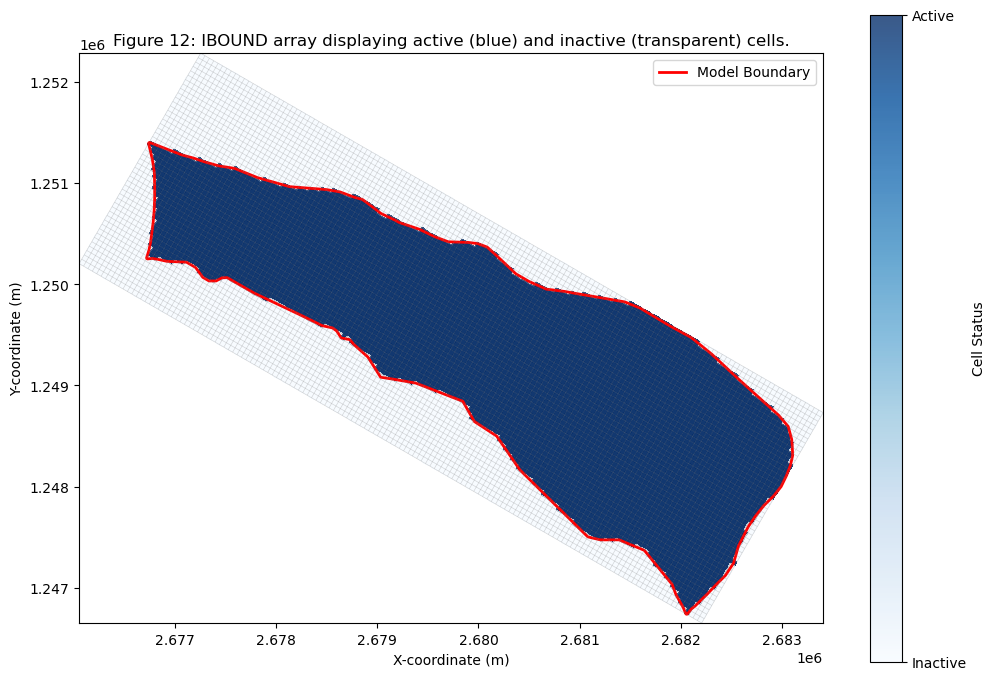

In [26]:
# --- 2. Visualization of IBOUND ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)

# Plot IBOUND array with custom colormap
# 0 = inactive (white), 1 = active (blue)
im = pmv.plot_array(ibound[0], cmap='Blues', vmin=0, vmax=1, alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.5)

# Overlay the original boundary for verification
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add colorbar
cbar = plt.colorbar(im, shrink=0.7, ticks=[0, 1])
cbar.ax.set_yticklabels(['Inactive', 'Active'])
cbar.set_label('Cell Status')

ax.set_title(f"Figure 12: IBOUND array displaying active (blue) and inactive (transparent) cells.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal', adjustable='box')

# Create custom legend handles to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line])

plt.show()

#### 4.1.3 Write IBOUND Array to the BAS package

In [27]:
# --- 3. Add IBOUND to the BAS6 package ---
# Create the BAS6 package with the IBOUND array
# Use model_top as initial heads
bas = flopy.modflow.ModflowBas(
    mf, 
    ibound=ibound, 
    strt=model_top,
    hnoflo=-999.99  # Head value for no-flow cells
)

print("\nBAS6 package created successfully with IBOUND array.")
print(f"Model has {active_cells} active cells out of {nrow_rotated * ncol_rotated} total cells")

# Diagnostic code to check IBOUND array
print("\n--- IBOUND Diagnostics ---")
print("IBOUND diagnostics:")
print(f"IBOUND shape: {ibound.shape}")
print(f"IBOUND layer 0 unique values: {np.unique(ibound[0])}")
print(f"Active cells (ibound=1): {np.sum(ibound[0] == 1)}")
print(f"Inactive cells (ibound=0): {np.sum(ibound[0] == 0)}")
print(f"Other values: {np.sum((ibound[0] != 0) & (ibound[0] != 1))}")


BAS6 package created successfully with IBOUND array.
Model has 4224 active cells out of 6816 total cells

--- IBOUND Diagnostics ---
IBOUND diagnostics:
IBOUND shape: (1, 48, 142)
IBOUND layer 0 unique values: [0 1]
Active cells (ibound=1): 4224
Inactive cells (ibound=0): 2592
Other values: 0


#### 4.1.4 Export IBOUND Array

In [28]:
# --- 4. Export IBOUND array ---
# Save the ibound array to a file for later use
ibound_file_path = os.path.join(workspace, 'ibound.npy')
np.save(ibound_file_path, ibound)

# Save the ibound array to a GeoDataFrame for visualization
ibound_cells = []
for i in range(nrow_rotated):
    for j in range(ncol_rotated):
        cell_polygon = modelgrid.get_cell_vertices(i, j)
        ibound_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': Polygon(cell_polygon),
            'ibound': int(ibound[0, i, j]),
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })  
# Create GeoDataFrame
ibound_gdf = gpd.GeoDataFrame(ibound_cells, crs=modelgrid.crs)  
# Export to GeoPackage
ibound_geopackage_path = os.path.join(workspace, 'ibound.gpkg')
ibound_gdf.to_file(ibound_geopackage_path, driver='GPKG', layer='ibound')

print(f"IBOUND array exported to: {ibound_geopackage_path}")

IBOUND array exported to: /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model/ibound.gpkg


#### 4.1.5 Identify Constant Head Cells
Oh, but we are not done yet! In MODFLOW, we have to assign IBOUND=-1 to the outflow cells along the western boundary.

The most straight forward way to select the cells with constant head is to load the IBOUND shape in QGIS and select the cells along the western boundary. See printscreen of QGIS in Figure 14. The selected features can then be exported as a shapefile and loaded into the notebook. The code below shows how to create the constant head boundary condition based on the selected cells.


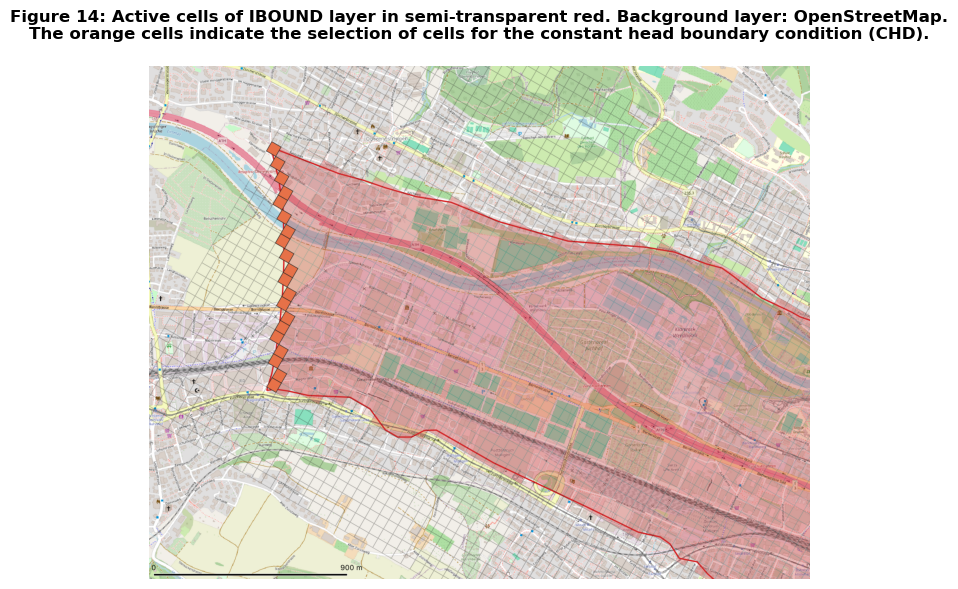

In [29]:
display_image(
    image_filename='selection_of_cells_for_chd_boundary_qgis.png', 
    image_folder='4_model_implementation',
    caption='Figure 14: Active cells of IBOUND layer in semi-transparent red. Background layer: OpenStreetMap. The orange cells indicate the selection of cells for the constant head boundary condition (CHD).'
)

#### 4.1.5 Add Constant Head Cells to BAS Package
Then, we load the cell selection to define the IBOUND cells we have to set to -1. For these same cells, we later assign a constant head boundary condition with the CHD package.

In [30]:
# Load the cell selection for the constant head boundary. 
chd_cells_path = download_named_file(
    name='chd_cells', 
    data_type='limmat_valley_model'
)

# Load CHD selection layer (assumes it only contains desired CHD cells)
chd_sel = gpd.read_file(chd_cells_path)
chd_sel = chd_sel.to_crs(modelgrid.crs)

# Reuse ibound_gdf (created earlier) as grid reference
if 'ibound_gdf' not in globals():
    raise RuntimeError("ibound_gdf not found. Ensure the IBOUND section was executed.")

# Ensure required columns
required_cols = {'cell_id', 'row', 'col'}
missing = required_cols - set(ibound_gdf.columns)
if missing:
    raise ValueError(f"ibound_gdf is missing required columns: {missing}")

if 'cell_id' not in chd_sel.columns:
    raise ValueError("CHD selection layer lacks 'cell_id'. Add it (e.g., from IBOUND export) and retry.")

# Normalize cell_id
chd_sel['cell_id'] = chd_sel['cell_id'].astype(str).str.strip()
ibound_gdf['cell_id'] = ibound_gdf['cell_id'].astype(str).str.strip()

# Join on cell_id
chd_join = chd_sel.merge(
    ibound_gdf[['cell_id']],
    on='cell_id',
    how='inner',
    validate='1:1'
)

if chd_join.empty:
    raise ValueError("No matching cell_id between CHD layer and ibound_gdf.")

# Vector filter to active cells
rows = chd_join['row'].astype(int).to_numpy()
cols = chd_join['col'].astype(int).to_numpy()
active_mask = ibound[0, rows, cols] == 1
chd_active = chd_join.loc[active_mask].drop_duplicates(subset=['row', 'col'])

if chd_active.empty:
    raise ValueError("Selected CHD cells are not active (ibound==1).")

# Assign constant head value
const_head_value = 390.0

# Set ibound to -1 for CHD cells
for r, c in zip(chd_active['row'].astype(int), chd_active['col'].astype(int)):
    ibound[0, r, c] = -1

# Update BAS package with modified ibound (recreate to be safe)
bas = flopy.modflow.ModflowBas(
    mf,
    ibound=ibound,
    strt=model_top,
    hnoflo=-999.99
)

chd_boundary_cells.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
chd_boundary_cells_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.


/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'chd_boundary_cells.gpkg': 'model_grid' (default), 'ibound'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:616: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:625: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(


In [31]:
create_nested_step_completion_marker(4, 1)

Checkbox(value=False, description='✅ Yes, I have completed Step 4.1: Boundary & Initial Conditions - Active Ce…

Output()

### 4.2 Lateral outflow - Constant head (CHD) Package 
The Constant Head (CHD) Package is used to fix hydraulic head values at selected cells in the model. These cells act as boundaries where groundwater can freely flow in or out, depending on the head gradient between the fixed boundary and the interior of the model.

**How it works**:
- The model keeps the specified head constant during the simulation.
- Water can leave (outflow) or enter (inflow) the model through these cells.
- The amount of flow is calculated by MODFLOW based on the head difference with neighboring cells and the conductance between them.

**Why we use it here**:
In our model, we apply a CHD boundary at the outflow of the aquifer. This ensures that groundwater can discharge naturally from the system while keeping the downstream head fixed at a realistic value.

👉 In practice: the CHD boundary represents a “hydraulic sink or source” that keeps the system open and allows water to move across the model boundary in a controlled way.

Number of CHD cells (from selection layer): 16

Constant head boundary package created with constant heads:
Constant head value: 390.0 m


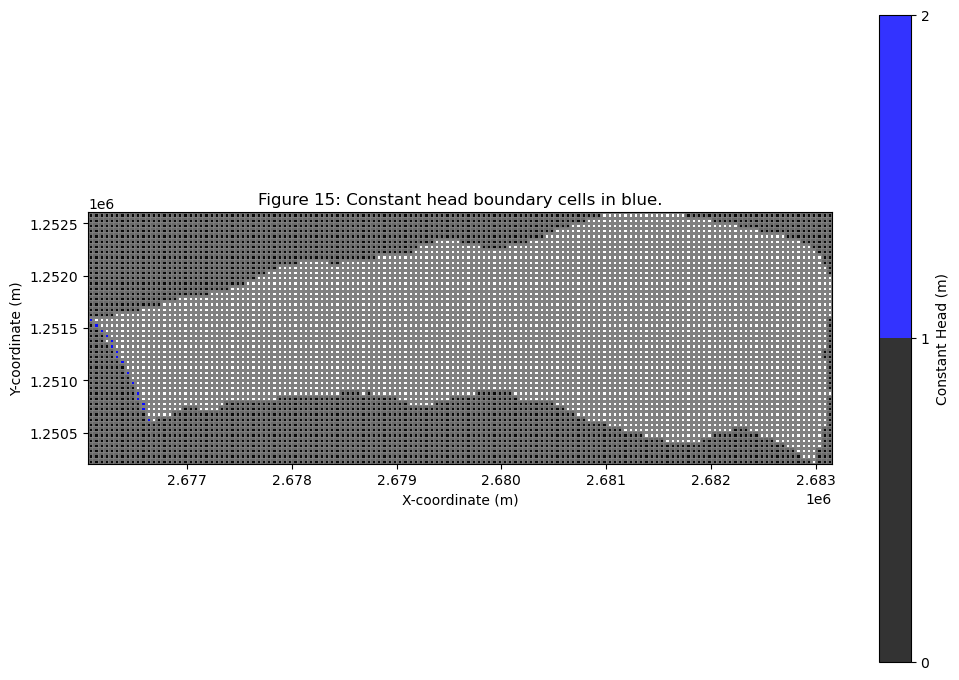

In [32]:
# Build CHD stress period data
chd_cells = [
    [0, int(r), int(c), const_head_value, const_head_value]
    for r, c in zip(chd_active['row'], chd_active['col'])
]

print(f"Number of CHD cells (from selection layer): {len(chd_cells)}")

# Build stress period data for constant head
chd = flopy.modflow.ModflowChd(
    mf,
    stress_period_data={0: chd_cells},
)

print("\nConstant head boundary package created with constant heads:")
print(f"Constant head value: {const_head_value} m")

# Plot the cells with constant head
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_bc(package=chd, color='blue', alpha=0.8, vmin=const_head_value, 
                 vmax=const_head_value)
pmv.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv.plot_grid(alpha=0.3, linewidth=0.2)
plt.colorbar(im, ax=ax, shrink=0.7, label="Constant Head (m)")
ax.set_title("Figure 15: Constant head boundary cells in blue.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')

plt.show()

In Figure 15, you can see the constant head boundary cells in blue. The cells are set to a fixed head value of 390 m a.s.l. and the IBOUND is set to -1 for these cells. This means that the model will maintain this head value in these cells throughout the simulation.  

In [33]:
create_nested_step_completion_marker(4, 2)

Checkbox(value=False, description='✅ Yes, I have completed Step 4.2: Boundary & Initial Conditions - Lateral O…

Output()

### 4.3 Net Areal Recharge (RCH Package)

Next, we tackle the **recharge from the top**: In the perceptual model chapter, we found that about 110 mm/year of net recharge is expected in the Limmat Valley. We will implement this as a uniform recharge across the model area. We defined the stress period length as 1 day, so we need to convert the annual recharge rate to a daily recharge rate. 


In [34]:
# Average net recharge value for the Limmat valley: 110 mm/year
rech_value = 0.110 / 365.25  # m/day
rech_array = np.full((nrow_rotated, ncol_rotated), rech_value, dtype=float)

rch = flopy.modflow.ModflowRch(
    mf, 
    rech=rech_array, 
    nrchop=3  # apply recharge to highest active cell in column
)

print("\nAreal recharge package created with constant rate:")
print(f"Recharge value: {rech_value:.6f} m/day")


Areal recharge package created with constant rate:
Recharge value: 0.000301 m/day


In [35]:
create_nested_step_completion_marker(4, 3)

Checkbox(value=False, description='✅ Yes, I have completed Step 4.3: Boundary & Initial Conditions - Areal Rec…

Output()

### 4.4 River Interaction (RIV Package)

Now we implement the river. We go for the RIV Package which is used to represent several conditions of loosing and gaining, connected and disconnected streams that are often present in shallow river-valley aquifers.

First, we get the river layer by the Canton of Zurich. we only keep the river layers in the model domain. We further discard the smaller rivers because we do not have any information about them and we assume that they are not contributing significantly to the groundwater flow in the Limmat Valley (see Figure 17). 

We'll further have to estimate a bottom elevation of the river as river profiles are not publicly available. We will linearly interpolate the river bottom elevation based an assumed average river depth for each river. 

Please note that in a paid project, you would optimally get access to more detailed river profile data. River profile data is available for the river stretches which are relevant for flood management. As a modeler, you will have to remember to ask your client for this data. However, in many parts of the world, river profile data is not available and you will have to make many assumptions about the river-aquifer interaction.   

> **Implementing Surface-Water–Groundwater Interaction in MODFLOW**
> 
> MODFLOW offers several ways to represent exchanges between rivers and aquifers. The choice depends on model goals, data availability, and desired level of detail:
>
> **Coarse**:  
> - *Constant Head (CHD)*: fixes head along a river reach → simple representation of boundary influence, but no feedback with aquifer conditions.
>
> **Intermediate**:
>
> - *Drain (DRN)*: removes water when groundwater is above river stage → simulates discharge but not recharge.
>
> - *River (RIV)*: allows two-way exchange based on stage, aquifer head, and riverbed conductance → widely used for river–aquifer interaction.
>
> **Detailed**:
>
> - *Streamflow Routing (SFR/SFR2)*: represents channel network, flow routing, stream gains/losses, and interactions with aquifer.
>
> - *Lake (LAK)*: simulates dynamic lake–aquifer exchange with surface water balance.
>
> Unsaturated Zone Flow (UZF): can simulate seepage from rivers or canals through the vadose zone to groundwater.
>
> 👉 In practice, many studies start with the RIV package and move toward SFR or LAK if surface water dynamics are important.

The following steps guide you through the rather complex process of implementing the RIV package in your MODFLOW model. But don't worry, we will break it down into manageable tasks.

1. Define the river geometry: This includes the river centerline, width, and depth. You can use GIS data to extract this information or make reasonable assumptions based on similar rivers in the region.

2. Assign riverbed elevations: Since we don't have detailed river profile data, we will need to make assumptions about the riverbed elevations. One approach is to use a digital elevation model (DEM) to estimate the riverbed elevation at each river cross-section.

3. Specify river hydraulic properties: This includes the riverbed hydraulic conductivity and the river stage. The hydraulic conductivity can be estimated based on soil and sediment characteristics, while the river stage can be derived from observed water levels or assumed based on regional data.

4. Implement the RIV package in MODFLOW: This involves defining the river cells in the model grid, specifying the river geometry and hydraulic properties, and setting up the necessary input files for MODFLOW.

5. Calibrate the model: Once the RIV package is implemented, you will need to calibrate the model to ensure that it accurately represents the river-aquifer interaction. This may involve adjusting the river hydraulic properties, refining the river geometry, or incorporating additional data.

6. Validate the model: Finally, you should validate the model by comparing the simulated river stages and flows with observed data. This will help ensure that the model is reliable and can be used for decision-making.


AV_Gewasser_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
AV_Gewasser_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Clipped river data columns:
Index(['OBJID', 'BFSNR', 'GEMEINDENAME', 'GEWAESSERNUMMER', 'GEWAESSERNAME',
       'ARTZHID', 'ARTZH', 'BEARBEITUNGSDATUM', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'],
      dtype='object')

Unique river names in the clipped data:
['Sihl' 'Schanzengraben' 'Limmat' 'Wasserwerk-Kanal' 'Döltschibach' ''
 'Wolfgrimmbach' 'Oerisbach' 'Albisrieder Dorfbach' 'Hauser-Kanal'
 'Hauser Kanal' 'Mühlehaldenbach' 'Altstetter Unterdorfbach' 'Bahngraben'
 'HWE Dorfbach' 'Dorfbach' 'Bombach' 'Fabrik-Kanal']


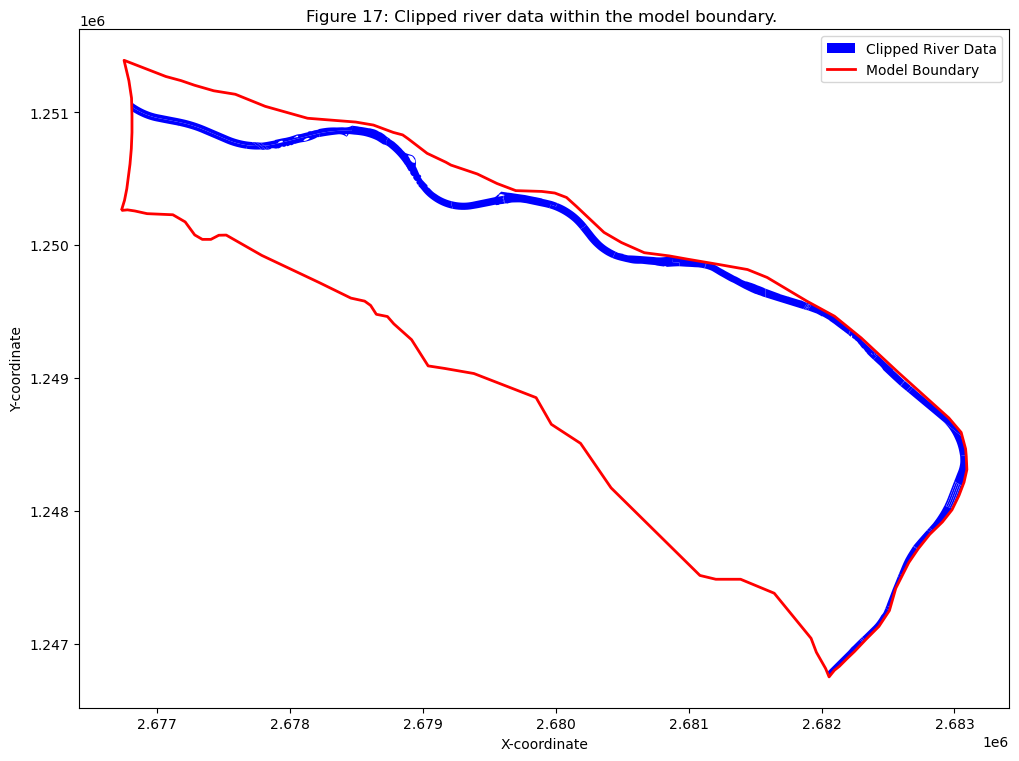

In [36]:
# Get the path to the river shapes and to the boundary outline
river_data_path = download_named_file(name='rivers', data_type='gis')
boundary_path = download_named_file(name='model_boundary', data_type='gis')

# Intersect the river data with the model grid and only keep the parts that are 
# inside the model boundary. 
river_gdf = gpd.read_file(river_data_path)
boundary_gdf = gpd.read_file(boundary_path)
# Ensure both GeoDataFrames are in the same CRS
river_gdf = river_gdf.to_crs(modelgrid.crs)
boundary_gdf = boundary_gdf.to_crs(modelgrid.crs)
# Clip the river data to the model boundary
river_clipped = gpd.clip(river_gdf, boundary_gdf)

# Print the column names of the clipped river data to understand its structure
print("Clipped river data columns:")
print(river_clipped.columns)
# Print the unique values in the 'GEWAESSERNAME' column to understand the river names
print("\nUnique river names in the clipped data:")
print(river_clipped['GEWAESSERNAME'].unique())

# We are interested in the river sections belonging to the rivers Sihl and Limmat. 
river_clipped = river_clipped[
    (river_clipped['GEWAESSERNAME'].isin(['Sihl', 'Limmat'])) 
].copy()

# Plot the clipped river data to verify
fig, ax = plt.subplots(figsize=(12, 12))
river_clipped.plot(ax=ax, color='blue', linewidth=2, label='Clipped River Data')
blue_polygon = mpatches.Patch(facecolor='blue', linewidth=2, label='Clipped River Data')
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.set_title("Figure 17: Clipped river data within the model boundary. ")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=[blue_polygon, red_line])
plt.show()

Now let's check if the elevation of the gauges on the river are consistent with the DEM. If the DEM is coarse and the river is narrow, the DEM might not capture the river elevation correctly. In this case, we might have to revert to a higher-resolution DEM that captures the river elevation better. If a higher-resolution DEM is not available, we can will have to carefully review the river elevation and adjust it manually if necessary. This will, in turn, make a bias correction of the river stage measurements necessary.

In [37]:
print("Summarizing river data ...")

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer="GS_LIMNIGRAPHENSTATIONEN_P")
gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)

# Keep only the gauges in the model area
gauges_gdf = gauges_gdf[gauges_gdf.geometry.within(gdf.union_all())]

# print("\nGauge information:")
# print(gauges_gdf[['LABEL', 'NAME']].head())

# We extracted the average river stage values from the gauges in 
# `2_perceptual_model.ipynb`. Let's use these values to check if the river stage
# is reasonable. The average river stage values are: 
river_data_path = os.path.join('case_study_zurich', 'data', 'rivers', 'river_data_summary.npy')
river_stage_summary = np.load(river_data_path, allow_pickle=True).item()
# Print the river stage summary to understand the values
# print("\nRiver stage summary:")
# print(river_stage_summary)
# The river stage summary is a nested dictionary with river names as keys and 
# with names of statistics as secondary key. We replace the river names with the 
# gauge labels to make it easier to match with the gauges.
# Create a mapping from river labels to river names in the river stage summary
label_to_river = {
    'LH  2099': 'limmat', 
    'LH  2176': 'sihl',
}
# Add 'mean' for each gauge to the gauges_gdf using the correct mapping
gauges_gdf['mean_stage_masl'] = gauges_gdf['LABEL'].map(
    lambda x: river_stage_summary.get(label_to_river.get(x, ''), {}).get('mean', np.nan)
)
# Round mean river stage values to 2 decimal places
gauges_gdf['mean_stage_masl'] = gauges_gdf['mean_stage_masl'].round(2)

# Print the updated gauges_gdf to verify
# print("\nUpdated gauges_gdf with mean river stage:")
# print(gauges_gdf[['LABEL', 'NAME', 'mean_stage_masl']])

# print("\nExtracting model_top values at gauge locations...")
# Check if gauges_gdf and mf.modelgrid have the same CRS
if gauges_gdf.crs != modelgrid.crs:
    print("Warning: CRS mismatch between gauges_gdf and modelgrid. Reprojecting...")
    gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)
# Print coordinates of gauges and model grid extent for debugging
# print("\nGauge coordinates:")
# for idx, gauge in gauges_gdf.iterrows():
#     print(f"Gauge {gauge['LABEL']} at ({gauge.geometry.centroid.x:.2f}, {gauge.geometry.centroid.y:.2f})")
# print("\nModel grid extent:")
# print(f"X range: {modelgrid.xcellcenters.min():.2f} to {modelgrid.xcellcenters.max():.2f}")
# print(f"Y range: {modelgrid.ycellcenters.min():.2f} to {modelgrid.ycellcenters.max():.2f}")

# Check if each gauge is within the model grid extent
# print("\nChecking if each gauge is within model grid extent:")
for idx, gauge in gauges_gdf.iterrows():
    gauge_x = gauge.geometry.x
    gauge_y = gauge.geometry.y
    
    xlim = (gauge_x > modelgrid.xcellcenters.min()) & (gauge_x < modelgrid.xcellcenters.max())
    ylim = (gauge_y > modelgrid.ycellcenters.min()) & (gauge_y < modelgrid.ycellcenters.max())
    
    within_bounds = xlim and ylim
    if not within_bounds:
        print(f"  WARNING: Gauge {gauge['LABEL']} is outside the model grid extent!")

# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex')

# Get model top values at gauge locations
model_top_at_gauges = []
gauge_cell_info = []

("\nUsing nearest neighbor approach for all gauges:")
for idx, gauge in gauges_gdf.iterrows():
    gauge_x, gauge_y = gauge.geometry.x, gauge.geometry.y
    
    # Calculate distances to all cell centers
    x_centers = modelgrid.xcellcenters
    y_centers = modelgrid.ycellcenters
    
    distances = np.sqrt((x_centers - gauge_x)**2 + (y_centers - gauge_y)**2)
    
    # Find the cell with minimum distance
    min_row, min_col = np.unravel_index(distances.argmin(), distances.shape)
    min_distance = distances[min_row, min_col]
    
    # Check if this cell is active
    is_active = ibound[0, min_row, min_col] == 1
    
    # Get the model top value at this cell
    top_value = modelgrid.top[min_row, min_col]
    
    # Add this to the dataframe
    gauges_gdf.loc[idx, 'model_top_masl'] = top_value

print("\nUpdated gauges_gdf with model top:")
print(gauges_gdf[['LABEL', 'NAME', 'mean_stage_masl', 'model_top_masl']])

Summarizing river data ...
Wasserpegel_-OGD.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Wasserpegel_-OGD_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.

Updated gauges_gdf with model top:
      LABEL                             NAME  mean_stage_masl  model_top_masl
5  LH  2099  Limmat-Zürich, Unterhard (BAFU)           400.29           402.5
6  LH  2176   Sihl-Zürich, Sihlhölzli (BAFU)           412.35           410.0


We see that the gauge level of the river Sihl is above the model top. The average elevation of the water level in the river is 412.35 m a.s.l. whereas the elevation of the grid cell is at 410 m a.s.l. For the river Limmat, we're ok. 

When you look for data to implement a numerical model, you will often encounter inconsistent data. This is a common issue in hydrological modeling, where different data sources may provide conflicting information about river stages, groundwater levels, and topography. You will have to factor in extra time to reconcile these discrepancies and ensure that your model is based on the best available data. Try to consult several independent data sources whenever possible.  

In the present case, we have several options:   
- Resample the model top from a higher-resolution DEM (way to go if a higher-resolution DEM is availble)
- Manually bias-correct the time series of the river water level in the river Sihl to be consistent with the model top (tedious but doable)
- Manually increase the DEM in the south-east corner of the model (last resort)

In the case of the Limmat valley aquifer, a higher resolution DEM is indeed available. The swissALTI3D model from the Swiss Federal Office of Topography (swisstopo), see Figure 18. If you are interested in how to download the DEM and to merge the tiles, please refer to the `processing_DEM.ipynb` in `SUPPPORT_REPO/src/scripts/scripts_limmat_data_preprocessing/`. 

swissalti3d_merged_lv95.tif already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
swissalti3d_merged_lv95_readme.pdf already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
DEM CRS: EPSG:2056
Model grid CRS: EPSG:2056
CRS are compatible, no transformation needed
DEM elevation range: 387.3 to 722.2 meters
DEM bounds: (2675999.9127667537, 2683999.9575791946, 1246000.03021355, 1252000.0638228806)


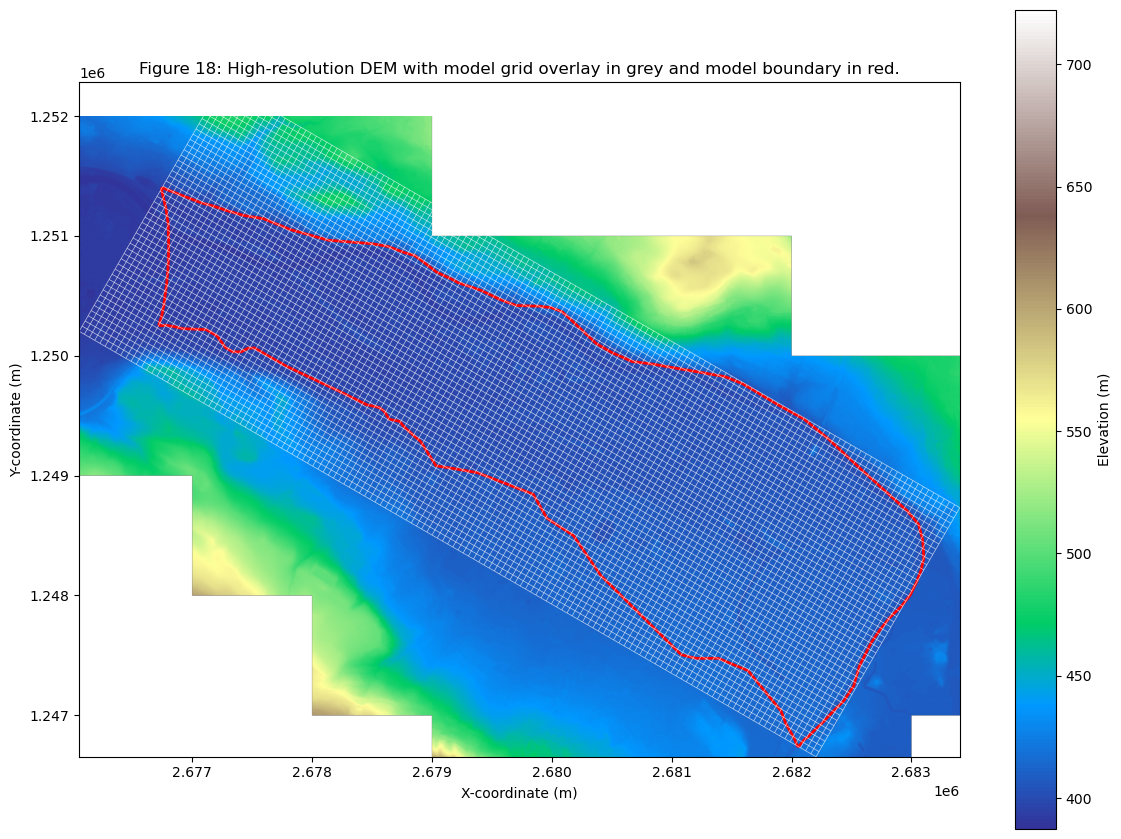

In [38]:
# Load the high-resolution DEM data
dem_path = download_named_file(
    name='dem_hres',
    data_type='gis'
)

# Check CRS compatibility first
with rasterio.open(dem_path) as src:
    dem_crs = src.crs
    print(f"DEM CRS: {dem_crs}")
    print(f"Model grid CRS: {modelgrid.crs}")
    
    if str(dem_crs) != str(modelgrid.crs):
        print("CRS transformation needed")
        
        # Get the bounds of the model grid in its CRS
        grid_bounds = modelgrid.extent
        
        # Transform model grid bounds to DEM CRS for cropping
        dem_bounds = transform_bounds(
            modelgrid.crs, dem_crs, 
            grid_bounds[0], grid_bounds[2], 
            grid_bounds[1], grid_bounds[3]
        )
        
        # Read and crop the DEM data
        window = src.window(*dem_bounds)
        dem_data = src.read(1, window=window)
        dem_transform = src.window_transform(window)
        
        # Now reproject the cropped DEM to match the model grid CRS
        dst_crs = modelgrid.crs
        dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
            dem_crs, dst_crs, dem_data.shape[1], dem_data.shape[0], *dem_bounds
        )
        
        # Create output array
        reprojected_dem = np.empty((dst_height, dst_width), dtype=dem_data.dtype)
        
        # Perform the reprojection
        reproject(
            dem_data,
            reprojected_dem,
            src_transform=dem_transform,
            src_crs=dem_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )
        
        # Create a temporary raster file with the reprojected data
        import tempfile
        with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
            tmp_path = tmp.name
            
        with rasterio.open(
            tmp_path, 'w',
            driver='GTiff',
            height=dst_height,
            width=dst_width,
            count=1,
            dtype=reprojected_dem.dtype,
            crs=dst_crs,
            transform=dst_transform,
        ) as dst:
            dst.write(reprojected_dem, 1)
        
        # Now load with FloPy Raster
        rio = Raster.load(tmp_path)
        
        # Clean up temporary file
        import os
        os.unlink(tmp_path)
        
    else:
        print("CRS are compatible, no transformation needed")
        rio = Raster.load(dem_path)

arr = rio.get_array(1)
# Mask values below 0 and set them to NaN
arr = np.where(arr <= 0, np.nan, arr)

idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
print(f"DEM elevation range: {vmin:.1f} to {vmax:.1f} meters")

# Get the minimum and maximum coordinates of the DEM file
dem_bounds = rio.bounds
print(f"DEM bounds: {dem_bounds}")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a masked array for plotting to handle NaN values properly
masked_arr = np.ma.masked_invalid(arr)

# Plot the raster with proper extent
im = ax.imshow(masked_arr, extent=rio.bounds, vmin=vmin, vmax=vmax, cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Elevation (m)")

# Plot the model grid on top
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(lw=0.5, color="white", alpha=0.7)
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_title("Figure 18: High-resolution DEM with model grid overlay in grey and model boundary in red.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
plt.tight_layout()
plt.show()


We resample the DEM to the model grid, looking for the minimum elevation values within each grid cell. This will help us to accurately represent the river elevations in the model.

Raster CRS: EPSG:2056
Grid CRS:   EPSG:2056


Text(0.5, 1.0, 'Figure 7: Resampled DEM on Model Grid with Buffered Model Boundary')

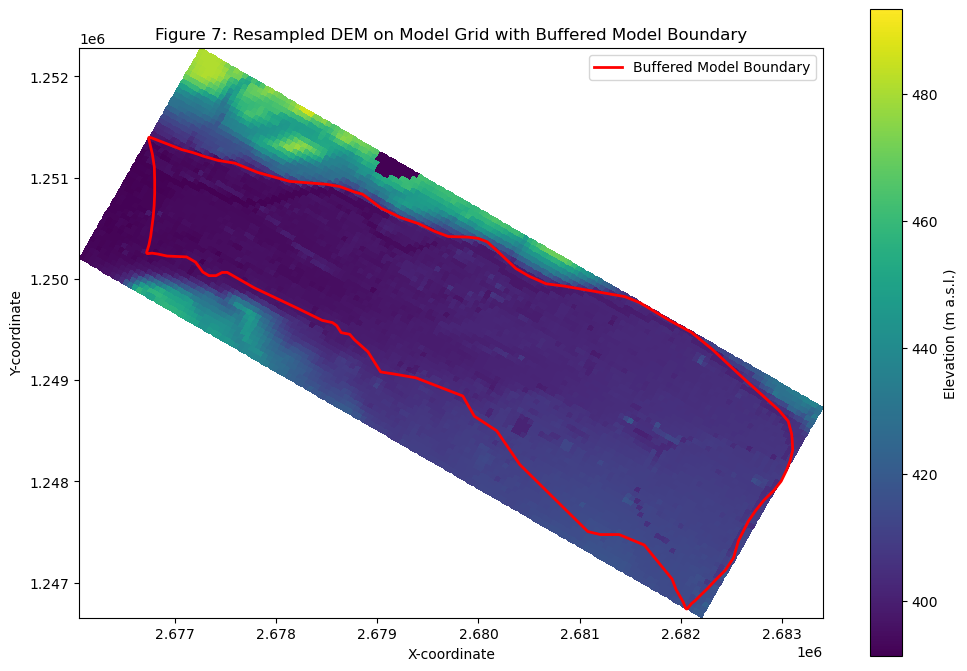

In [39]:
# --- Resample the high-resolution DEM ---
# Verify CRS alignment
print("Raster CRS:", rio.crs)
print("Grid CRS:  ", modelgrid.crs)

# Depending on the resolution of the DEM, resampling can be computationally 
# intensive.
t0 = time.time() # To log the time it takes to resample the DEM
model_top_hres = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# Build a valid-data mask (exclude nodata and non-finite)
valid = np.isfinite(model_top)
for nod in (rio.nodatavals or []):
    if nod is not None:
        valid &= model_top != nod

# Also drop absurd magnitudes (typical float32 nodata)
valid &= np.abs(model_top) < 1e6

# We round to 10 centimeters to avoid having to store too many digits
model_top_hres = np.round(model_top_hres, 1)

# Compute robust vmin/vmax
if np.any(valid):
    vmin, vmax = np.nanmin(model_top[valid]), np.nanmax(model_top[valid])
else:
    raise RuntimeError("No valid DEM samples on the grid. Check CRS/projection.")


# Now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_top_hres, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)

# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 7: Resampled DEM on Model Grid with Buffered Model Boundary")

This is our new model top. 

#### Delineating River Cells and Assigning Elevations
With our model grid established, we now need to tell the model exactly where the rivers are located and define their physical properties. We'll use our model grid layer (IBOUND) and a Digital Elevation Model (DEM) to accomplish this. The goal is to create the key input for the River (RIV) Package: a list of active river cells and their corresponding bottom elevations (rbot).

**1. Selecting River Cells from the Grid**
The first step is to identify which specific grid cells represent the Sihl and Limmat rivers. We can overlay our river shapes with the model grid and select the intersecting cells.

Action: We loaded the IBOUND grid layer into QGIS. Using the "Select Features" tool, we manually selected each cell that the Sihl and Limmat rivers flow through.

Important Consideration: During selection, we ensured that the path of river cells was continuous. Each cell in the river is connected to the next one by sharing a cell face, not just a corner. This is best practice for the River (RIV) Package ensuring conceptual integrity and an absolute requirement for advanced packages like the Streamflow Routing (SFR) Package.

Output: The selected cells were then saved as a new GeoPackage layer named river_cells.gpkg. This gives us a clean, isolated layer containing only the cells that will make up our rivers.

**2. Extracting Riverbed Elevation (rbot)**
Each river cell in the model needs a riverbed elevation (rbot). This value represents the bottom of the river channel and is used to determine whether the river is losing water to the aquifer or gaining water from it.

Action: We used the Zonal Statistics tool in QGIS.

Zones Layer: river_cells.gpkg

Raster Layer: The project's high-resolution DEM.

Statistic to calculate: Minimum

Why the 'Minimum' Value? A single model cell (e.g., 50x50 meters) covers a significant area. The river channel within that cell will naturally occupy the lowest point. By extracting the minimum elevation from the DEM within each cell's boundary, we get a very good approximation of the true riverbed elevation.

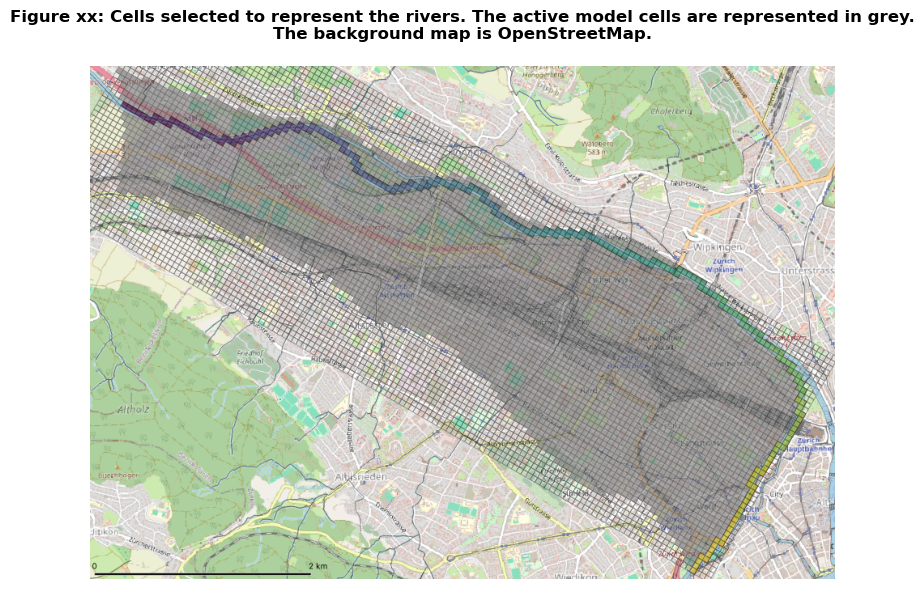

In [40]:
display_image(
    image_filename='river_cells_qgis.png', 
    image_folder='4_model_implementation',
    caption='Figure xx: Cells selected to represent the rivers. The active model cells are represented in grey. The background map is OpenStreetMap.'
)

**3. Quality Control and Manual Correction**
Automated processes are powerful, but they aren't perfect and require a "reality check." A river's elevation profile should consistently and smoothly decrease as it flows downstream—water doesn't flow uphill!

Action: We inspected the minimum elevation values generated by Zonal Statistics. We discovered an issue near the Zürich Hauptbahnhof (main station). Here, the Sihl river flows through a tunnel beneath the railway tracks.

The Problem: The DEM represents the surface elevation, which in this case is the top of the train station and tracks, not the hidden riverbed below. This resulted in artificially high rbot values.

The Solution: We manually edited the attribute table for the river_cells layer, correcting these values based on known engineering plans or logical interpolation. This ensured we have a monotonically decreasing riverbed profile, which is physically realistic.

With these steps complete, we now have a river_cells.gpkg file where each polygon represents a specific model cell and has a corrected attribute for its riverbed elevation. This is the perfect input for building our FloPy river package.

Let's have a look at the river bottoms (rbot) we've extracted.

river_cells.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
river_cells_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
     row  col cell_id  ibound             x             y river_name  \
0      0  108   0_108       1  2.681941e+06  1.249548e+06       None   
1      0  109   0_109       1  2.681985e+06  1.249523e+06       None   
2      0  110   0_110       1  2.682028e+06  1.249498e+06       None   
3      0  111   0_111       1  2.682071e+06  1.249473e+06       None   
4      0  112   0_112       1  2.682115e+06  1.249448e+06       None   
..   ...  ...     ...     ...           ...           ...        ...   
220   44  138  44_138       1  2.682140e+06  1.246893e+06       Sihl   
221   44  139  44_139       1  2.682184e+06  1.246868e+06       Sihl   
222   45  138  45_138       1  2.682115e+06  1.246850e+06       Sihl   
223   46  138  46_138       1  2.682090e+06  1.246806e+06

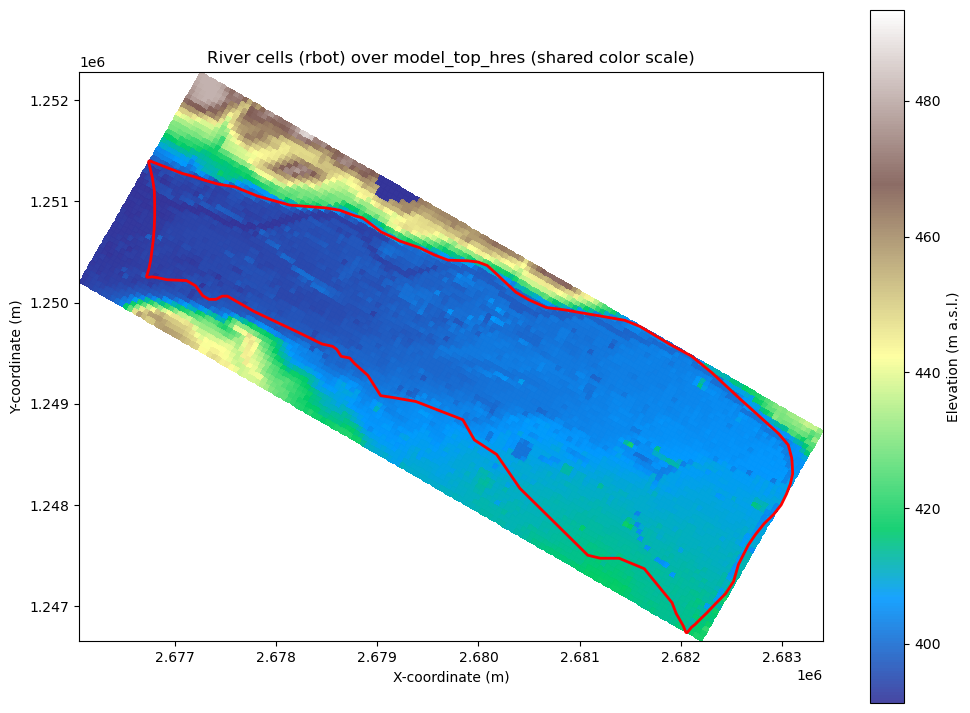

In [41]:
# Get the riverbed elevations (rbot) from the river_cells layer
river_cells_path = download_named_file(
    name="river_cells", 
    data_type="limmat_valley_model"
    )
# Plot river cells over DEM with the same color scale
# Load river cells and align CRS
river_cells_gdf = gpd.read_file(river_cells_path)
river_cells_gdf = river_cells_gdf.to_crs(modelgrid.crs)
# Print the features of river_cells_gdf
print(river_cells_gdf)

# Pick the riverbed elevation column (try common names)
rbot_candidates = ['rbot', 'r_bottom', 'rbed', 'rbed_elev', 'rbot_m',
                   'min', '_min', 'MIN', 'min_elev', 'z_min', 'Z_MIN']
rbot_col = next((c for c in rbot_candidates if c in river_cells_gdf.columns), None)
if rbot_col is None:
    raise ValueError(f"No riverbed elevation column found. Available columns: {list(river_cells_gdf.columns)}")

# Ensure row/col indices for placing values on the grid
def _find_index_col(gdf, name_opts):
    for n in name_opts:
        if n in gdf.columns:
            return n
    return None

row_col_name = _find_index_col(river_cells_gdf, ['row', 'ROW', 'i'])
col_col_name = _find_index_col(river_cells_gdf, ['col', 'COL', 'j'])

if row_col_name is None or col_col_name is None:
    # Fallback: spatial join with ibound_gdf if available
    if 'ibound_gdf' in globals():
        joined = gpd.sjoin(river_cells_gdf, ibound_gdf[['cell_id','row','col','geometry']], how='left', predicate='intersects')
        if joined[['row','col']].isna().any().any():
            raise ValueError("Could not map all river cells to grid indices via ibound_gdf.")
        river_cells_gdf['row'] = joined['row'].astype(int)
        river_cells_gdf['col'] = joined['col'].astype(int)
        row_col_name, col_col_name = 'row', 'col'
    else:
        # Last resort: use GridIntersect
        ix = GridIntersect(modelgrid, method='vertex', rtree=True)
        rows_list, cols_list = [], []
        for _, feat in river_cells_gdf.iterrows():
            res = ix.intersect(feat.geometry)
            if len(res) == 0:
                rows_list.append(np.nan); cols_list.append(np.nan)
            else:
                # take the first intersecting cell (cells should be unique per feature)
                rr = int(res.iloc[0]['row']); cc = int(res.iloc[0]['col'])
                rows_list.append(rr); cols_list.append(cc)
        river_cells_gdf['row'] = rows_list
        river_cells_gdf['col'] = cols_list
        if river_cells_gdf[['row','col']].isna().any().any():
            raise ValueError("Could not map some river cells to grid indices (GridIntersect).")
        row_col_name, col_col_name = 'row', 'col'

# Build an array of riverbed elevations on the model grid
river_rbot_array = np.full((nrow_rotated, ncol_rotated), np.nan, dtype=float)
for _, r in river_cells_gdf.iterrows():
    i = int(r[row_col_name]); j = int(r[col_col_name])
    if 0 <= i < nrow_rotated and 0 <= j < ncol_rotated:
        river_rbot_array[i, j] = float(r[rbot_col])

# Use the same color scale as model_top_hres
valid_top = np.isfinite(model_top_hres) & (np.abs(model_top_hres) < 1e6)
if not np.any(valid_top):
    raise RuntimeError("model_top_hres has no valid values to define color scale.")
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)

# Base DEM (high‑res resampled)
im = pmv.plot_array(model_top_hres, vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.9)

# Overlay river cells, colored by rbot, using the same vmin/vmax/cmap
#pmv.plot_array(np.ma.masked_invalid(river_rbot_array), vmin=vmin, vmax=vmax, cmap=cmap, alpha=1.0)

# Boundary outline
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Model boundary')

# Colorbar reflects the shared scale
cb = plt.colorbar(im, ax=ax, shrink=0.75, label="Elevation (m a.s.l.)")

ax.set_title("River cells (rbot) over model_top_hres (shared color scale)")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')
plt.show()

We see by the darker blue of the river in the downstream part that the river bottom elevation is below the surrounding DEM, as we expect. Let's see if in the river bottom is below the DEM of the river cells everywhere. We take the difference between the two.

River cells: 225 | negatives (rbot above ground): 1


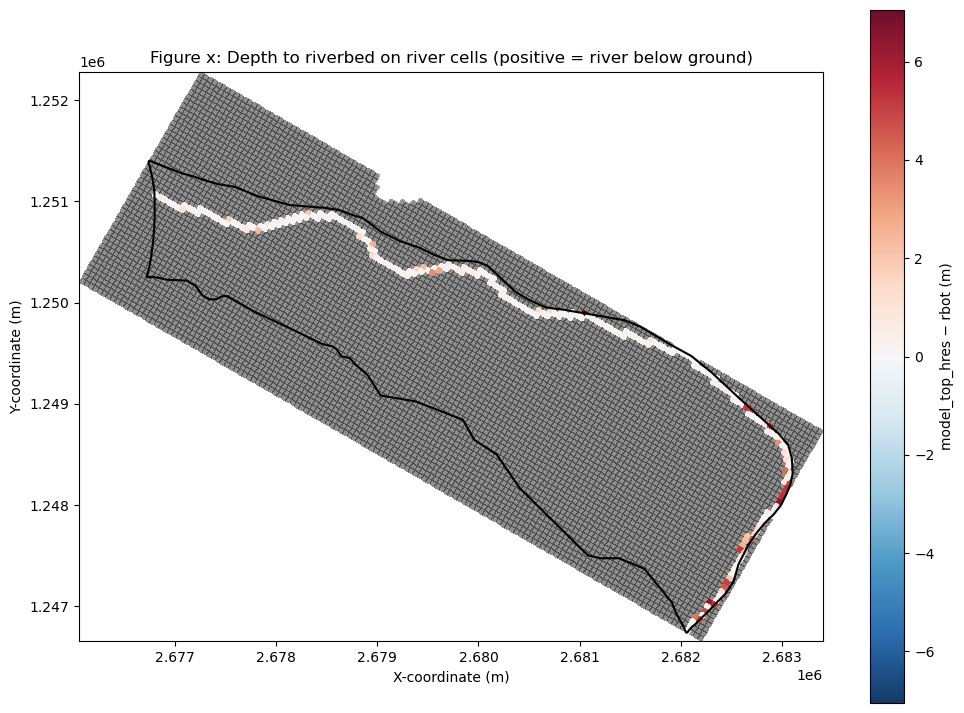

In [42]:
# Depth-to-riverbed on river cells: positive if riverbed is below ground, negative if inconsistent
river_mask = np.isfinite(river_rbot_array) & np.isfinite(model_top_hres)
if not np.any(river_mask):
    raise RuntimeError("No valid river rbot values found to compute differences.")

depth_to_riverbed = model_top_hres - river_rbot_array
depth_to_riverbed_masked = np.ma.masked_where(~river_mask, depth_to_riverbed)

# Symmetric color scale around 0 to make inconsistencies visible
absmax = np.nanmax(np.abs(depth_to_riverbed[river_mask]))
vmin_diff, vmax_diff = -absmax, absmax if np.isfinite(absmax) and absmax > 0 else (-1, 1)

fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)

# Optional: faint base for context
pmv.plot_array(model_top_hres, cmap="Greys", alpha=0.25)

# Plot only river cells with a diverging cmap centered at 0
im = pmv.plot_array(
    depth_to_riverbed_masked,
    cmap="RdBu_r",
    vmin=vmin_diff,
    vmax=vmax_diff,
    alpha=0.95
)

# Boundary
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label='Model boundary')

cb = plt.colorbar(im, ax=ax, shrink=0.75, label="model_top_hres − rbot (m)")
ax.set_title("Figure x: Depth to riverbed on river cells (positive = river below ground)")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')

# Quick summary in console
neg_cnt = np.sum(depth_to_riverbed[river_mask] < 0)
print(f"River cells: {river_mask.sum()} | negatives (rbot above ground): {neg_cnt}")

plt.show()

We have consistently lower river bottom than model top. Now we define other parameters of the River (RIV) package.

#### Write RIV package 
The River (RIV) package represents rivers that can either gain water from or lose water to the aquifer, depending on the hydraulic gradient. Unlike the CHD package, which fixes heads, the RIV package simulates a dynamic head-dependent flux boundary.

In Flopy, each active river cell requires three main parameters:

1. **Stage** – the river water level (m).

2. **Conductance** – the hydraulic connection between the river and the aquifer. It is usually computed as:

$$𝐶=𝐾_{riverbed}⋅\frac{𝑊⋅𝐿}{𝑀}$$

where 
$K_{riverbed}$ = riverbed hydraulic conductivity,  
$W$ = river width,  
$L$ = river reach length,  
$M$ = riverbed thickness.  

3. **Riverbed Bottom Elevation** – the elevation of the base of the riverbed (m). This ensures that if the aquifer head drops below this level, no more seepage to the river occurs.

Please have a look at the Section on the River-Aquifer Interaction in the second notebook on the Perceptual model to be reminded of how the flux is calculated.

In [43]:
# Define the RIV package
# Parameters
# Leakage coefficient as estimated in perceptual model chapter:
q_riv_sihl = 1.3e-6 * 86400  # 1/day
q_riv_limmat = 3.5e-6 * 86400  # 1/day

riverbed_thickness = 0.5    # m, typical assumption
riverbed_k_sihl = q_riv_sihl * riverbed_thickness  # m/d (hydraulic conductivity of riverbed)
riverbed_k_limmat = q_riv_limmat * riverbed_thickness  # m/d (hydraulic conductivity of riverbed)

# Average river depth estimated in perceptual model chapter:
sihl_depth_mean = 0.3
limmat_depth_mean = 0.7
min_stage_clearance = 0.05  # m above rbot to avoid stage==rbot
# Optional width by river name (if attribute present on river_cells_gdf)
width_by_name = {
    'Limmat': 30.0,  # m
    'Sihl':   15.0,  # m
}
default_width = 15.0  # m (used if river name is not available)

# Find a river name column, if any
river_name_col = None
for cand in ['GEWAESSERNAME', 'name', 'river', 'river_name', 'Name', 'gew_name']:
    if cand in river_cells_gdf.columns:
        river_name_col = cand
        break

# Build RIV stress period data
riv_spd = []  # Initialize river stress period data
n_skipped = 0  

# Exclude CHD cells from RIV
chd_cells_set = set()
if 'chd' in globals():
    try:
        chd_cells_set = {(int(c[1]), int(c[2])) for c in chd.stress_period_data[0]}
    except Exception:
        chd_cells_set = set()

for _, rec in river_cells_gdf.iterrows():
    i = int(rec['row'])
    j = int(rec['col'])

    # Skip if out of grid or not active
    if not (0 <= i < nrow_rotated and 0 <= j < ncol_rotated):
        n_skipped += 1
        continue
    if ibound[0, i, j] != 1:
        # Exclude inactive (0) and CHD (-1) cells
        n_skipped += 1
        continue
    if (i, j) in chd_cells_set:
        n_skipped += 1
        continue

    # Assign river bottom elevation (rbot)
    rbot = float(rec[rbot_col])
    if not np.isfinite(rbot):
        n_skipped += 1
        continue

    # Choose width (W)
    if river_name_col is not None and isinstance(rec[river_name_col], str):
        W = width_by_name.get(rec[river_name_col], default_width)
    else:
        W = default_width

    # Approximate reach length (L) for a cell
    # Using min of delr/delc at this location (uniform here, ~cell_size)
    L = float(min(delr_rotated[j], delc_rotated[i]))

    # Conductance: C = K_riverbed * (W * L) / M  [units: m^2/day]
    if river_name_col is not None and isinstance(rec[river_name_col], str):
        cond = (riverbed_k_limmat if rec[river_name_col] == 'Limmat' else riverbed_k_sihl) * (W * L) / riverbed_thickness
    else:
        cond = riverbed_k_sihl * (W * L) / riverbed_thickness

    # Stage: put the water surface slightly above rbot
    if river_name_col is not None and isinstance(rec[river_name_col], str):
        stage = rbot + (sihl_depth_mean if rec[river_name_col] == 'Sihl' else limmat_depth_mean)
    else:
        stage = rbot + sihl_depth_mean

    # Optional cap to remain below ground (if DEM available at cell)
    if 'model_top_hres' in globals() and np.isfinite(model_top_hres[i, j]):
        stage = min(stage, model_top_hres[i, j] - min_stage_clearance)

    # Ensure stage is above rbot
    if stage <= rbot:
        stage = rbot + min_stage_clearance

    riv_spd.append([0, i, j, float(stage), float(cond), float(rbot)])

print(f"RIV cells prepared: {len(riv_spd)} (skipped: {n_skipped})")

# 3) Create/replace the RIV package
riv = flopy.modflow.ModflowRiv(
    mf,
    stress_period_data={0: riv_spd},
    ipakcb=53  # enable cbc output for river package
)

print("RIV package created.")

RIV cells prepared: 224 (skipped: 1)
RIV package created.


#### Update the DIS package
We also have to update the model button and make sure the river bottom is consistently below the aquifer bottom. 

River cells checked: 225
Problem cells (botm > rbot): 5


row  col        botm        rbot  botm_minus_rbot
0    3   89  403.400000  398.346863         5.053137
3    4  132  404.200000  401.096313         3.103687
2    3  127  403.697033  400.902557         2.794476
1    3  126  403.393613  400.770966         2.622647
4    6  135  402.800000  401.495209         1.304791

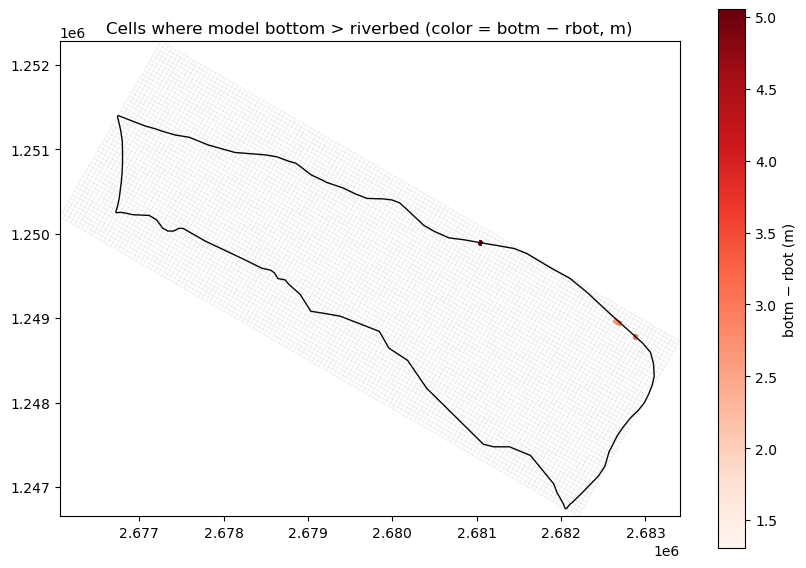

In [44]:
# Re-calculate model bottom, enforce a minimum aquifer thickness of at least 2 m
model_bottom_hres = model_top_hres - np.maximum(aquifer_thickness_resampled, 2)

# Let's check if the model bottom is below the river bottom
# Masks
river_mask = np.isfinite(river_rbot_array)           # only river cells
active_mask = ibound[0] != 0                         # exclude fully inactive cells
check_mask = river_mask & active_mask

# Difference: botm - rbot
diff = model_bottom_hres - river_rbot_array
problem_mask = check_mask & (diff > 0)

n_checked = int(np.nansum(check_mask))
n_problem = int(np.nansum(problem_mask))
print(f"River cells checked: {n_checked}")
print(f"Problem cells (botm > rbot): {n_problem}")

# Show top 10 violations
if n_problem:
    ii, jj = np.where(problem_mask)
    violations = pd.DataFrame({
        'row': ii,
        'col': jj,
        'botm': model_bottom_hres[ii, jj],
        'rbot': river_rbot_array[ii, jj],
        'botm_minus_rbot': diff[ii, jj],
    }).sort_values('botm_minus_rbot', ascending=False)
    display(violations.head(10))

# Plot map of problem cells (colored by botm - rbot)
fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
plot_arr = np.where(problem_mask, diff, np.nan)
im = pmv.plot_array(plot_arr, cmap='Reds')
pmv.plot_grid(alpha=0.2, linewidth=0.4)
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
ax.set_title("Cells where model bottom > riverbed (color = botm − rbot, m)")
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, shrink=0.7, label='botm − rbot (m)')
plt.show()


At a few locations at the model boundary, the river bottom is below the model bottom. We will lower the model bottom to 2 m below the river bottom at these locations. 

River cells checked: 225
Problem cells (botm > rbot): 0


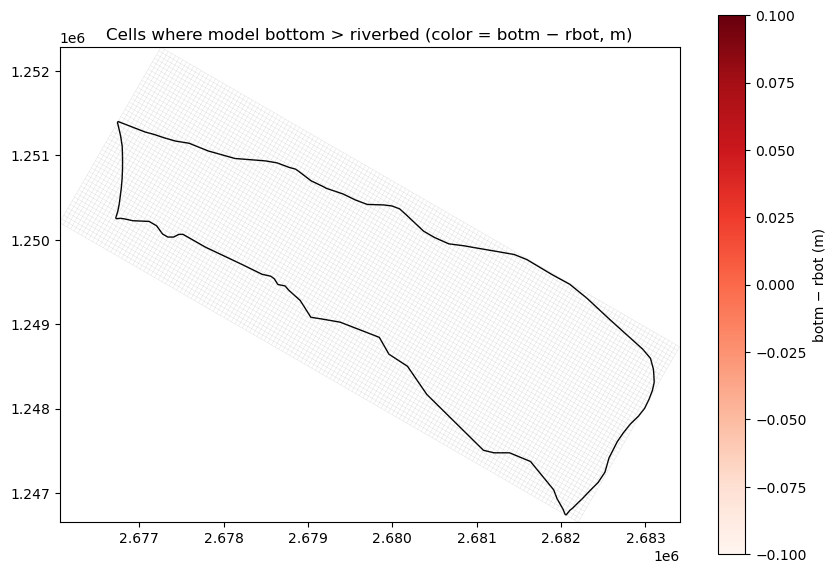

In [45]:
# Update the model bottom where it is below the river bottom
model_bottom_hres[problem_mask] = river_rbot_array[problem_mask] - 2

# Visual check
# Difference: botm - rbot
diff = model_bottom_hres - river_rbot_array
problem_mask = check_mask & (diff > 0)

n_checked = int(np.nansum(check_mask))
n_problem = int(np.nansum(problem_mask))
print(f"River cells checked: {n_checked}")
print(f"Problem cells (botm > rbot): {n_problem}")

# Show top 10 violations
if n_problem:
    ii, jj = np.where(problem_mask)
    violations = pd.DataFrame({
        'row': ii,
        'col': jj,
        'botm': model_bottom_hres[ii, jj],
        'rbot': river_rbot_array[ii, jj],
        'botm_minus_rbot': diff[ii, jj],
    }).sort_values('botm_minus_rbot', ascending=False)
    display(violations.head(10))

# Plot map of problem cells (colored by botm - rbot)
fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
plot_arr = np.where(problem_mask, diff, np.nan)
im = pmv.plot_array(plot_arr, cmap='Reds')
pmv.plot_grid(alpha=0.2, linewidth=0.4)
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
ax.set_title("Cells where model bottom > riverbed (color = botm − rbot, m)")
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, shrink=0.7, label='botm − rbot (m)')
plt.show()

Now we can update the DIS package. 

In [46]:
# Update the DIS package
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top_hres,
    botm=model_bottom_hres,
    xoff=xmin_original,
    yoff=ymin_original,
    angrot=-grid_rotation_angle,
    lenuni=2,
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady
)

/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:616: UserWarning: Unit 11 of package DIS already in use.
  warn(
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:625: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


### 4.5 Groundwater Pumping & Lateral Inflow - Well (WEL) Package

Next we tackle the **lateral inflows from the north and the south** of the model. We will implement these as recharge wells with specified rates. In Chapter 2 - Perceptual Model, we estimate the lateral inflows to be about 20% of the annual precipiation of 1100 mm/year on an area of 11 km2 in the north and 15 km2 in the south. These amounts have to be distributed along the northern and southern boundaries of the model. We will do the same trick with the selection of cells for in QGIS as for the constant head boundary condition. The code below shows how to create the lateral inflow boundary condition based on the selected cells.

lateral_north_boundary_cells.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
lateral_north_boundary_cells_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
lateral_south_boundary_cells.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
lateral_south_boundary_cells_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/limmat_valley_model.
Lateral inflow north total: 6625.60 m3/d over 137 cells (each 48.362 m3/d)
Lateral inflow south total: 9034.91 m3/d over 127 cells (each 71.141 m3/d)
Combined injected via WEL: 15660.51 m3/d
WEL package created for lateral inflows.


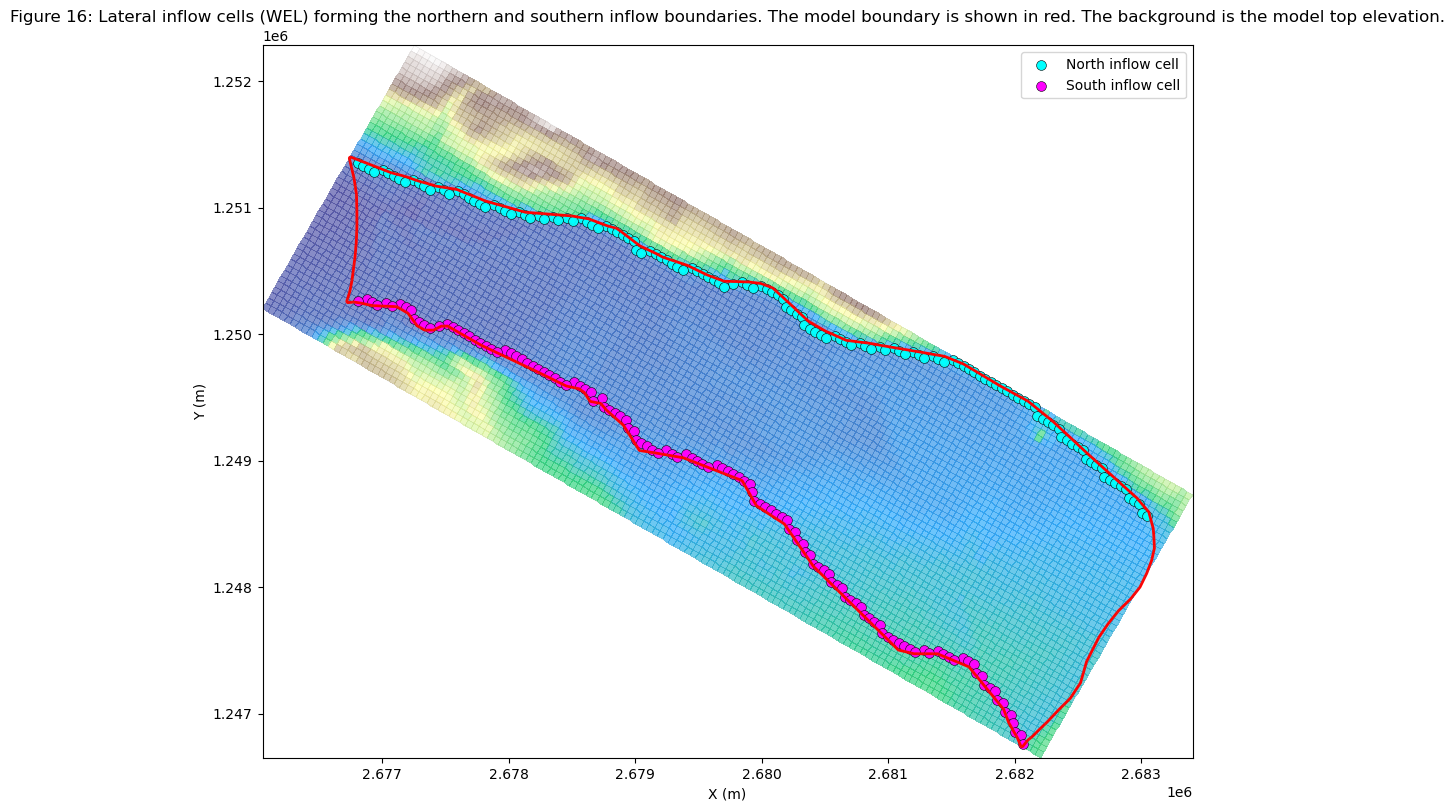

In [47]:
# Each selected boundary cell receives an equal share of the total inflow
# Positive WEL rates inject water (MODFLOW convention)
inflow_north = 0.2 * 1.100 * 11000000 / 365.25  # m3/day
inflow_south = 0.2 * 1.100 * 15000000 / 365.25  # m3/day

wells_north_path = download_named_file(
    name='wells_north', 
    data_type='limmat_valley_model'
)
wells_south_path = download_named_file(
    name='wells_south', 
    data_type='limmat_valley_model'
)

# Load selections
wells_north_gdf = gpd.read_file(wells_north_path).to_crs(modelgrid.crs)
wells_south_gdf = gpd.read_file(wells_south_path).to_crs(modelgrid.crs)

if 'ibound_gdf' not in globals():
    raise RuntimeError("ibound_gdf not in scope. Run IBOUND section first.")

for need in ['cell_id', 'row', 'col', 'ibound']:
    if need not in ibound_gdf.columns:
        raise ValueError(f"ibound_gdf missing column: {need}")

for g in (wells_north_gdf, wells_south_gdf):
    if 'cell_id' not in g.columns:
        raise ValueError("Boundary well selection layers must contain 'cell_id' (export from ibound layer).")

# Normalize identifiers
ibound_gdf['cell_id'] = ibound_gdf['cell_id'].astype(str).str.strip()
wells_north_gdf['cell_id'] = wells_north_gdf['cell_id'].astype(str).str.strip()
wells_south_gdf['cell_id'] = wells_south_gdf['cell_id'].astype(str).str.strip()

def prepare_boundary(df_sel, label):
    joined = df_sel.merge(
        ibound_gdf[['cell_id']],
        on='cell_id',
        how='inner',
        validate='1:1'
    )
    if joined.empty:
        raise ValueError(f"No matching cell_id for {label} boundary selection.")
    # Keep active (ibound==1) only (exclude inactive and CHD cells)
    joined = joined.loc[joined['ibound'] == 1].drop_duplicates(subset=['row','col'])
    joined['row'] = joined['row'].astype(int)
    joined['col'] = joined['col'].astype(int)
    return joined

north_cells = prepare_boundary(wells_north_gdf, "north")
south_cells = prepare_boundary(wells_south_gdf, "south")

n_north = len(north_cells)
n_south = len(south_cells)

if n_north == 0:
    raise ValueError("North boundary selection has no active non-CHD cells.")
if n_south == 0:
    raise ValueError("South boundary selection has no active non-CHD cells.")

# Distribute uniformly
q_north_each = inflow_north / n_north
q_south_each = inflow_south / n_south

# Build stress period data list: [lay, row, col, flux]
wel_spd = []
for _, r in north_cells.iterrows():
    wel_spd.append([0, r.row, r.col, q_north_each])
for _, r in south_cells.iterrows():
    wel_spd.append([0, r.row, r.col, q_south_each])

total_assigned = sum(w[3] for w in wel_spd)
print(f"Lateral inflow north total: {inflow_north:.2f} m3/d over {n_north} cells "
      f"(each {q_north_each:.3f} m3/d)")
print(f"Lateral inflow south total: {inflow_south:.2f} m3/d over {n_south} cells "
      f"(each {q_south_each:.3f} m3/d)")
print(f"Combined injected via WEL: {total_assigned:.2f} m3/d")

# Create / replace WEL package
wel = flopy.modflow.ModflowWel(
    mf,
    stress_period_data={0: wel_spd},
    ipakcb=53
)

print("WEL package created for lateral inflows.")

# Plot wells
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(alpha=0.2, linewidth=0.4)
pmv.plot_array(model_top, alpha=0.35, cmap='terrain')
# Symbol size scaled (simple)
for qlist, color, label in [(north_cells, 'cyan', 'North inflow cell'),
                            (south_cells, 'magenta', 'South inflow cell')]:
    ax.scatter(
        modelgrid.xcellcenters[qlist['row'], qlist['col']],
        modelgrid.ycellcenters[qlist['row'], qlist['col']],
        c=color, s=50, edgecolors='k', linewidths=0.4, label=label
    )
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_title("Figure 16: Lateral inflow cells (WEL) forming the northern and southern inflow boundaries. The model boundary is shown in red. The background is the model top elevation.")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
ax.legend()
plt.show()

# Quick check: ensure no CHD overlap
overlap = []
if 'chd' in globals():
    chd_cells_set = {(c[1], c[2]) for c in chd.stress_period_data[0]}
    for w in wel_spd:
        if (w[1], w[2]) in chd_cells_set:
            overlap.append((w[1], w[2]))
if overlap:
    print(f"Warning: {len(overlap)} WEL cells overlap CHD cells (they will be ignored by MODFLOW).")


## 5 Solver and Output Control (PCG & OC Packages)

We need to tell MODFLOW how to solve the system of equations. The **Preconditioned Conjugate-Gradient (PCG)** package is a robust and commonly used solver. We also need to specify what results we want to save using the **Output Control (OC)** package. We are interested in saving the head and budget results.

In [48]:
# --- 7. Solver and Output Control ---
# Add the PCG solver
pcg = flopy.modflow.ModflowPcg(mf, mxiter=50, iter1=30)

# Specify output control
oc = flopy.modflow.ModflowOc(
    mf, 
    # Save head and budget at the end of each stress period
    stress_period_data={(0, 0): ['save head', 'save budget']}
)

In [49]:
create_nested_step_completion_marker(5)

Checkbox(value=False, description='✅ Yes, I have completed Step 5: Solver & Output Control', indent=False, lay…

Output()

## 6 Run the model
Now that we have defined all the necessary packages, we can run the model. We will use the `write_input` method to write all the input files and then use the `run_model` method to execute the simulation.

### 6.1 Write and inspect input files
We start by writing the input files using the `write_input` method.

In [50]:
# Write input files
mf.write_input()

Please find the newly created files in your working directory. You should see a list of files called limmat_valley_model with different file endings, reflecting the package structure of a MODFLOW model, for example: 
- .nam
- .dis
- .bas
- .lpf
- .pcg
- .oc
All of the above files can be opened in your default text editor. Since flopy conveniently handles reading and writing of these files for us, we will not go into detail about the contents of each package. We do, however, want to highlight the importance of the following file for debugging your model:

#### .nam file
The .nam file is the name file for the MODFLOW model. It contains the names of all the input files that MODFLOW will use during the simulation. This file is essential for running the model, as it tells MODFLOW where to find the necessary input data.  

You can check if all the required input files are listed in the .nam file by opening it in a text editor and verifying the file names.

### 6.2 Check if the modflow model setup is consistent
Modflow has a model check utility that can be used to verify the consistency of the model setup. This utility checks for common errors and inconsistencies in the model input files, such as missing or misconfigured packages, and provides helpful error messages to guide the user in fixing any issues.

Be prepared to address any errors or warnings that the utility may find before proceeding with the model simulation.

In [51]:
# run FloPy's built-in input checker (prints a summary)
chk = mf.check(f=None, verbose=True)


limmat_valley_model MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    BAS6 package: isolated cells in ibound array

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    BAS6 package: Not a number
    CHD packa

We get a warning about an isolated cell in the model domain. This means that there is at least one cell that is not connected to any other cells, which can cause issues during the simulation for example if this cell recieves recharge but has no outflow. We need to investigate the model grid and the boundary conditions to ensure that all cells are properly connected.


In [52]:
active = (ibound[0] == 1)
# 4-neighbor count
nbr = (
    np.pad(active[1:, :], ((0,1),(0,0))) +  # up
    np.pad(active[:-1, :], ((1,0),(0,0))) + # down
    np.pad(active[:, 1:], ((0,0),(0,1))) +  # right
    np.pad(active[:, :-1], ((0,0),(1,0)))   # left
)
isolated = active & (nbr == 0)

n_isolated = int(isolated.sum())
print(f"Isolated active cells: {n_isolated}")

if n_isolated:
    ibound[0, isolated] = 0  # deactivate
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=model_top, hnoflo=-999.99)

Isolated active cells: 1


/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:616: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:625: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(


Let's rerun the model check utility to verify the updated model setup.

In [53]:
chk = mf.check(f=None, verbose=True)


limmat_valley_model MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    BAS6 package: isolated cells in ibound array
    BAS6 package: No

Now we eliminated the warnings. Let's proceed with the model simulation.

### 6.3 Model Simulation
We now attempt a forward simulation to observe the model behavior over time. run_model will produce an output file that contains the simulation results (.list). 

In [ ]:
# Run the model
success, buff = mf.run_model(silent=True, report=True)

# We print the last lines of the listing file in case the model run fails.
if not success:
    print("Model did not run successfully. Reading listing file tail...")
    lst_path = os.path.join(workspace, f"{model_name}.list")
    if os.path.exists(lst_path):
        with open(lst_path, "r", errors="ignore") as f:
            lst_tail = f.read().splitlines()[-200:]
        print("---- tail of listing (.list) ----")
        print("\n".join(lst_tail))
    else:
        print(f"Listing file not found at: {lst_path}")

Model did not run successfully. Reading listing file tail...
---- tail of listing (.list) ----
     65      1      7     71       397.8           84.24           397.5    
     66      1      7     84       398.0           84.24           397.7    
     67      1      7     85       397.8           84.24           397.7    
     68      1      7     86       397.9           84.24           397.9    
     69      1      7    136       401.8           84.24           401.5    
     70      1      7    137       402.0           84.24           402.0    
     71      1      7    138       402.1           84.24           402.1    
     72      1      8     65       397.8           84.24           397.5    
     73      1      8     66       397.6           84.24           397.5    
     74      1      8     67       397.7           84.24           397.4    
     75      1      8     68       397.5           84.24           397.5    
     76      1      8     71       397.5           84.24  

We get the error that a constant head cell ran dry. This indicates that the model is not properly accounting for the boundary conditions or the hydraulic properties of the aquifer. We need to investigate the model setup, particularly the initial conditions and the boundary conditions applied to the constant head cells.

Let's try reducing the hydraulic conductivities in the model by a factor of 10 and see if that resolves the issue.

In [62]:
# Reduce hydraulic conductivities in the layer property flow package by a factor of 10
scale = 0.1
lpf.hk.set_data(lpf.hk.array * scale)
lpf.vka.set_data(lpf.vka.array * scale)

# Re-write the input files
mf.write_input()

# Re-check the model
mf.check()

# Run the model
success, buff = mf.run_model(report=True)

AttributeError: 'Util3d' object has no attribute 'set_data'

### 6.4 Typical run-time issues in MODFLOW (with Flopy) — and how to fix them
Don't despair if your model doesn't run successfully (this is the default). Here are some common issues and strategies of how to fix them:

- Geometry conflicts (negative thickness / inverted layers): top < botm or botm(k-1) < botm(k) causes aborts.
Fix: enforce a minimum thickness, repair ordering top→bottom, deactivate outcrops; add assertions after building arrays.

- Dry/oscillating heads: cells go dry near rivers/wells or heads bounce and won’t converge.
Fix: enable LPF wetting (IWETIT, WETFCT), reduce time-step size (smaller DELT/nper), moderate boundary conductances, refine grid or smooth parameter contrasts.

- Convergence failures (solver): “failed to converge” with large mass-balance errors.
Fix: tighten or relax tolerances sensibly (HCLOSE, RCLOSE), increase iteration limits (MXITER, ITER1), switch/improve solver (e.g., PCG→GMG if available), reduce parameter contrasts, shorten stress periods.

- Units & magnitudes off: m/s vs m/d, recharge too large, conductance orders-of-magnitude high.
Fix: decide on a consistent unit system (m, days), back-calc plausible ranges (e.g., riv conductance), sanity-check budgets.

- Bad/stale stress data: stage below riverbed, wells in inactive cells, missing data in later stress periods.
Fix: validate every SP: river stage > rbot, stresses only on active cells, explicitly provide or carry forward data for each period.

- Package/grid size mismatches: array shapes don’t match nlay/nrow/ncol.
Fix: check shapes before write_input(), broadcast carefully, and inspect warnings in the .lst.

- Executable & workspace issues: wrong exe_name, files not written, or running in another folder.
Fix: call m.write_input(), verify m.exe_name, set a clean model_ws, then success, buff = m.run_model(report=True).

**Diagnosing quickly**: always read the list file for the first failing step, check water budget residuals, and plot heads/budgets after each run to see where issues originate.

## 7 Visualize results for first sanity checks